<h2>Data gathering </h2>

Donwload and extract the dataset

In [1]:
!kaggle datasets download camnugent/california-housing-prices
!unzip california-housing-prices.zip

Dataset URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices
License(s): CC0-1.0
  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 41.1MB/s]
Archive:  california-housing-prices.zip
  inflating: housing.csv             


In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import mutual_info_classif


Check the presence of null: very few, I decided to fill them with the average value.

This may not be the best choice in general, however, due to their minimal influence, it shouldn't be a big deal.

In [3]:
seed = 17

# load dataset from csv
data = pd.read_csv('housing.csv')

# count nulls in each column
null_counts = data.isnull().sum()
print(null_counts)

# handle missing values by filling them with the mean (imputation)
numeric_cols = data.select_dtypes(include=['number']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())


# transform ocean_proximity into indexed variable using LabelEncoder to feed KMeans with numbers instead of strings
label_encoder = LabelEncoder()
data['ocean_proximity_indexed'] = label_encoder.fit_transform(data['ocean_proximity'])

data = data.drop(columns=['ocean_proximity'])

data

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       ocean_proximity_indexed  
0                            3  
1                            3  
2                            3  
3                            3  
4                            3  
...                        ...  
20635                        1  
20636                        1  
20637                        1  
20638                        1  
20639                        1  

[20640 rows x 10 columns]

<h2> Clustering cost estimation </h2>

I found some already impelmented techniques both for Silhouette and for the cost of K-Means clusters. However, especially for Silhouette, not knowing how they worked in the first place made me think about how to implement it. Eventually I used the already implemented functions, however my personal imeplementation yields the same results (being however of course less efficient).

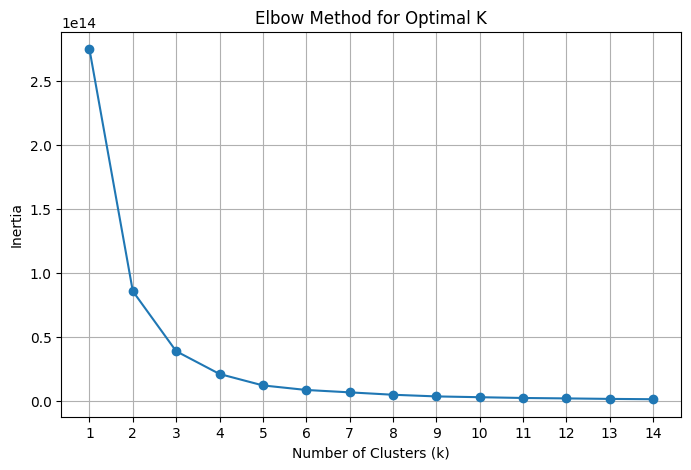

In [4]:
def kmeansCost(data, centroids, labels):
    cost = 0
    for i, point in enumerate(data):
        # get the centroid for the current point's cluster
        centroid = centroids[labels[i]]
        # add squared distance to the cost
        cost += np.sum((point - centroid) ** 2)
    return cost


# apply K-Means clustering with the elbow method
def kmeansElbow(data, k_values=range(1, 15)):
    costs = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
        labels = kmeans.fit_predict(data)
        centroids = kmeans.cluster_centers_
        costs.append(kmeans.inertia_)

        # check that the parameter corresponds to k-means++ clustering cost
        #cost = kmeansCost(data.to_numpy(), centroids, labels)
        #print(f"Inertia for k={k}: {cost}, {kmeans.inertia_}")


    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, costs, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()
    return costs

costs = kmeansElbow(data)


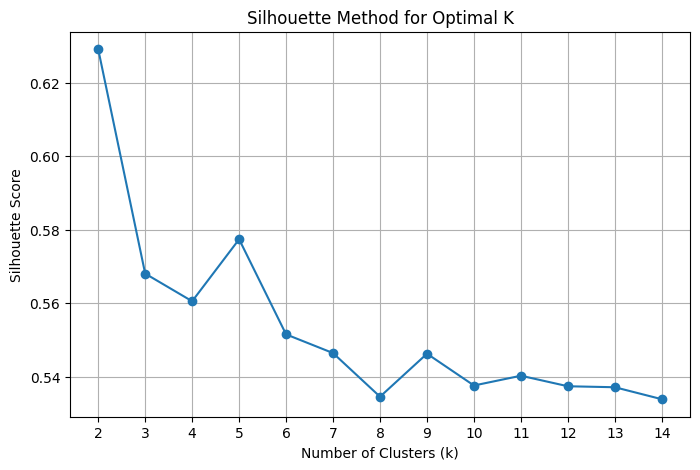

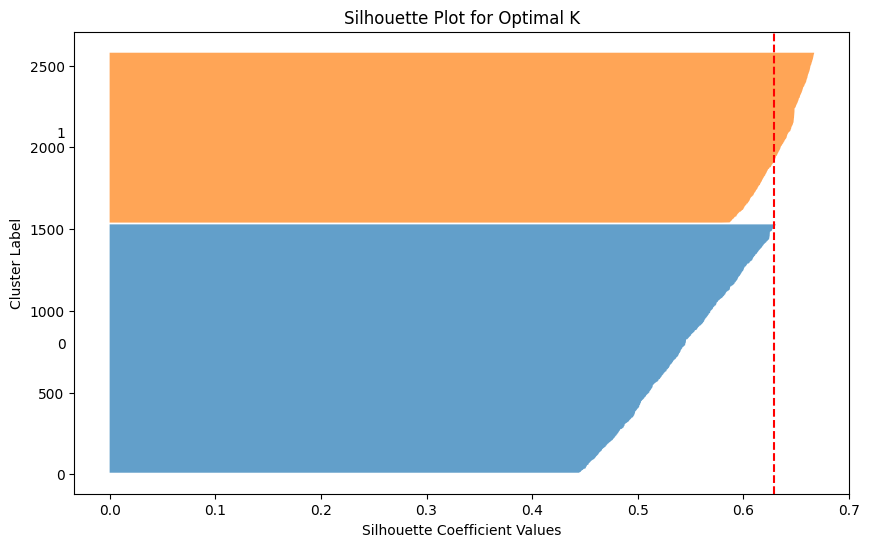

In [5]:
# remember that silhouette has a quadratic cost overall, this is why I tried as much as possible
# to leverage on numpy functions (which are way more efficient), to be able to test my function
def silhouette(data, labels):
    n = data.shape[0]
    # initialize the silhouette scores
    scores = np.zeros(n)
    # get the number of clusters
    clusters = len(np.unique(labels))

    for i in range(n):
        point = data[i]
        cluster_id = labels[i]

        # points in the same cluster (clustered_points)
        same_cluster_points = data[labels == cluster_id]
        # number of points in the same cluster
        same_cluster_size = len(same_cluster_points)

        # the cluster contains only one point: silhouette score is 0 (checkout wikipedia for the reasoning behind this neutral choice)
        if same_cluster_size == 1:
            scores[i] = 0
            continue

        # calculate a_i (average distance to other points in the same cluster)
        a_i = np.sum(np.linalg.norm(same_cluster_points - point, axis=1)) / (same_cluster_size - 1)

        # b_i (minimum average distance to points in other clusters)
        b_i = float('inf')
        # here the intense usage of numpy functions allowed me to avoid cycling on the whole dataset again (at least with python)
        # numpy C-implemented functions will scan all the other clusters for me :)
        for other_cluster in range(clusters):
            if other_cluster != cluster_id:
                # points in the other cluster
                other_cluster_points = data[labels == other_cluster]
                b_i = min(b_i, np.mean(np.linalg.norm(other_cluster_points - point, axis=1)))

        scores[i] = (b_i - a_i) / max(a_i, b_i)

    # return the overall silhouette score (average over all points)
    return np.mean(scores)

def kmeansSilhouette(data, k_values=range(2, 15), plot=True):

    silhouette_scores = []

    # compute silhouette scores for different numbers of clusters
    for k in k_values:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)

        # check correctness of my implementation
        #print(f"Silhouette Score for k={k}: {score}, {silhouette(data.to_numpy(), labels)}")

        silhouette_scores.append(score)

    # print the optimal number of clusters
    optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
    #print(f"The optimal number of clusters is: {optimal_k}")
    if plot:
        # plot silhouette scores
        plt.figure(figsize=(8, 5))
        plt.plot(k_values, silhouette_scores, marker='o')
        plt.title('Silhouette Method for Optimal K')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.xticks(k_values)
        plt.grid(True)
        plt.show()

        kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=seed)
        clusters = kmeans.fit_predict(data)
        sample_silhouette_values = silhouette_samples(data, clusters)

        # plot silhouette scores for each cluster (cool graphics)
        plt.figure(figsize=(10, 6))
        y_lower = 10
        for i in range(optimal_k):
            # aggregate silhouette scores for points in cluster i
            ith_cluster_values = sample_silhouette_values[labels == i]
            ith_cluster_values.sort()

            size_cluster_i = ith_cluster_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # fill bar for cluster i
            plt.fill_betweenx(
                np.arange(y_lower, y_upper),
                0, ith_cluster_values, alpha=0.7
            )
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # Leave some space between clusters

        plt.title("Silhouette Plot for Optimal K")
        plt.xlabel("Silhouette Coefficient Values")
        plt.ylabel("Cluster Label")
        plt.axvline(x=np.mean(sample_silhouette_values), color="red", linestyle="--")
        plt.show()

    return optimal_k, silhouette_scores

optimal_k, silhouette_scores = kmeansSilhouette(data)

<h2> K-Means </h2>

The functions here implemented allow to:

*   Project the points in a 2D-space using PCA (which in scikit-learn implementation does not rescale features, as they are only centered).
*   Scatter Plot the 2d points for visualization.
*   Visualize the results of K-Means on the points, using the above mentioned scatter plot.

The last function allows to run a complete experiment: after using the two functions to find the optimal k, it visualizes the results of the clustering both in the original not rescaled space and in the normalized features space.

This is because I wanted to check the possibility that a clustering in one of the spaces could work well also by rescaling it into the other.
Hence, after normalizing the points and the centroids, I visualized the results of the clustering also in the normalized space.

K-Means cost: 85985081604777.97
Silhouette Score: 0.6290927375641541
PCA Components:
[[-7.98043175e-07 -2.66838390e-06  1.15177844e-05  2.53710308e-03
   1.79836668e-04 -2.41510816e-04  2.18291633e-04  1.13282065e-05
   9.99996712e-01  1.00642888e-06]
 [ 5.11747063e-05 -3.34124771e-05 -1.89419230e-03  8.78810816e-01
   1.61747210e-01  4.24104027e-01  1.47162425e-01  6.62151327e-05
  -2.18840648e-03 -2.05459161e-05]]

Explained Variance Ratio:
[9.99528879e-01 4.48991297e-04]


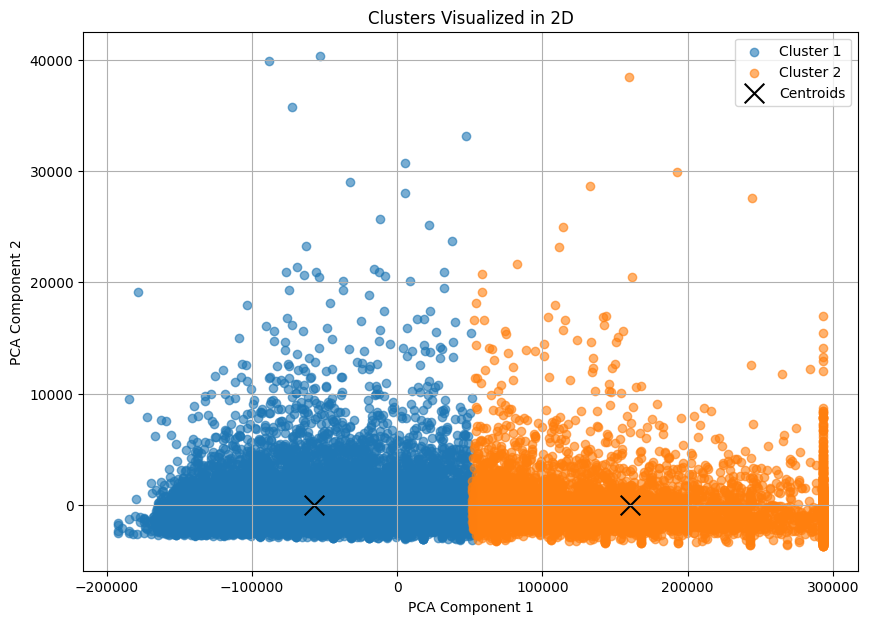

Mutual information between features and clusters: 
 [0.10102357 0.09402151 0.01134013 0.01562175 0.         0.00553638
 0.         0.17496045 0.57594251 0.07141631] 

PCA Components:
[[ 0.08088749 -0.07974957 -0.21782962  0.48367185  0.48766916  0.47010739
   0.4900286   0.05599757  0.04454124 -0.04048663]
 [ 0.66290207 -0.65810308 -0.02694328 -0.07988895 -0.07619695 -0.03877429
  -0.07792379  0.08122493  0.07178021 -0.30857991]]

Explained Variance Ratio:
[0.3911263  0.20247532]


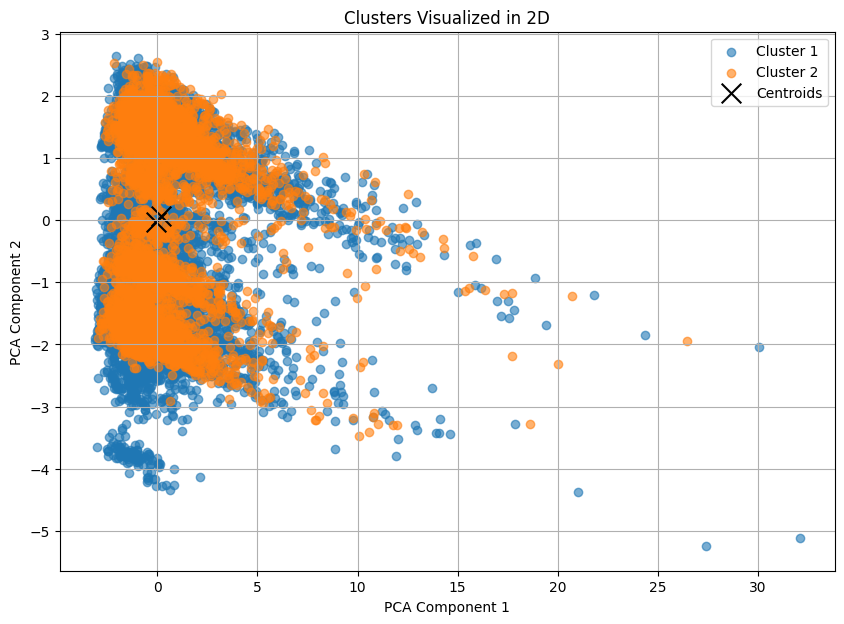

Time needed to run K-Means: 2.09808349609375e-05


In [6]:
def visualizeKMeans(data, optimal_k):
    data_np = data.to_numpy() if isinstance(data, pd.DataFrame) else data
    # fit the K-Means model with the optimal number of clusters
    start_time = time()
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=seed)
    elapsed_time = time() - start_time
    clusters = kmeans.fit_predict(data_np)
    centroids = kmeans.cluster_centers_
    print(f"K-Means cost: {kmeans.inertia_}")
    print(f"Silhouette Score: {silhouette(data_np, clusters)}")
    # visualize the results
    data_2d, centroids_2d = dataTo2d(data_np, centroids)
    scatterplotClusters(data_2d, clusters, centroids_2d)

    return clusters, centroids, elapsed_time

def dataTo2d(data, centroids):
    # reduce dimensionality of the points using PCA
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids)
    print("PCA Components:")
    print(pca.components_)


    # print the explained variance ratio
    print("\nExplained Variance Ratio:")
    print(pca.explained_variance_ratio_)

    return data_2d, centroids_2d

def scatterplotClusters(data_2d, clusters, centroids_2d):
    # plot the clusters
    plt.figure(figsize=(10, 7))
    # unique elements
    for cluster in set(clusters):
        plt.scatter(data_2d[clusters == cluster, 0], data_2d[clusters == cluster, 1],
                    label=f'Cluster {cluster + 1}', alpha=0.6)
    # plot cluster centroids (transformed to 2D using PCA)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='black', marker='x', s=200, label='Centroids')
    plt.title('Clusters Visualized in 2D')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluateKMeans(data):
    #kmeansElbow(data)
    optimal_k, _ = kmeansSilhouette(data, plot=False)
    clusters, centroids, elapsed_time = visualizeKMeans(data, optimal_k)
    # compute mutual information for each feature

    mi_scores = mutual_info_classif(data, clusters, random_state=seed)
    print(f"Mutual information between features and clusters: \n {mi_scores} \n")

    return clusters, centroids, elapsed_time

def evaluateKMeansOnRawData(data, not_normalize=[]):
    clusters, centroids, elapsed_time = evaluateKMeans(data)
    scaler = StandardScaler()
    data_np = data.to_numpy() if isinstance(data, pd.DataFrame) else data

    # create a mask to exclude the one-hot encoded features from normalization
    mask = np.ones(data_np.shape[1], dtype=bool)
    mask[not_normalize] = False

    # normalize the features
    data_scaled = scaler.fit_transform(data_np[:, mask])
    centroids_scaled = scaler.transform(centroids[:, mask])

    # concatenate with the one-hot encoded features
    data_scaled = np.concatenate((data_scaled, data_np[:, ~mask]), axis=1)
    centroids_scaled = np.concatenate((centroids_scaled, centroids[:, ~mask]), axis=1)

    # plot in the normalized features space.
    data_2d, centroids_2d = dataTo2d(data_scaled, centroids_scaled)
    scatterplotClusters(data_2d, clusters, centroids_2d)
    return clusters, centroids, elapsed_time

clusters, centroids, elapsed_time = evaluateKMeansOnRawData(data)
print(f"Time needed to run K-Means: {elapsed_time}")

<h2>Error analysis</h2>

It is clear that in the raw features space the median_house_value field has by far the highest standard deviation (115395.6), as it is the highest component in the first PCA vector (with a value of almost 1, so roughly the direction of the vector	with the highest variance).

Therefore any clustering on the raw data, also with higher values of k, will cluster the points based on its value.

Notice also that in the normalized features space the clustering on raw data is quite a mess.


<h2> One-Hot Encoding and EDA </h2>

First, we can refine a bit our data, by applying One-Hot Encoding to the ocean_proximity categorical field, which was previously simply indexed.

Let us also check out a bit our data.

In [7]:
# one hot encode the indexed feature
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_array = one_hot_encoder.fit_transform(data[['ocean_proximity_indexed']])

# convert the one-hot encoded array into a DataFrame using categories as names
encoded_columns = [f"ocean_proximity_{category}" for category in label_encoder.classes_]
encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns)

# drop the indexed feature
data = data.drop(columns=['ocean_proximity_indexed'])
# append the one hot encoded features
data = pd.concat([data, encoded_df], axis=1)

# these features will be excluded from normalization in following experiments
ocean_features = data.columns[-5:]
ocean_feature_indices = [data.columns.get_loc(col) for col in ocean_features]

data

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
0                            0.0                     0.0   
1                            0.0                     0.0   
2                            0.0                     0.0   
3                            0.0                     0.0   
4                            0.0                     0.0   
...                          ...                     ...   
20635                        0.0                     1.0   
20636                        0.0                     1.0   
20637                        0.0                     1.0   
20638                        0.0                     1.0   
20639                        0.0                     1.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
0                         0.0                       1.0   
1                         0.0                       1.0   
2                         0.0                       1.0   
3                         0.0                       1.0   
4                         0.0                       1.0   
...                       ...                       ...   
20635                     0.0                       0.0   
20636                     0.0                       0.0   
20637                     0.0                       0.0   
20638                     0.0                       0.0   
20639                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  
...                           ...  
20635                         0.0  
20636                         0.0  
20637                         0.0  
20638                         0.0  
20639                         0.0  

[20640 rows x 14 columns]

Here it can be seen why the median_house_value variance dominates all the other fields and understand the results of the previous data.

The second component with the highest variance, which was the second principal component previously identified by PCA, is the total_rooms field, with the second highest variance.

In [8]:
data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        419.266592   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    787.000000    280.000000       2.563400   
50%        438.000000   1166.000000    409.000000       3.534800   
75%        643.250000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
count        20640.000000               20640.000000            20640.000000   
mean        206855.816909                   0.442636                0.317393   
std         115395.615874                   0.496710                0.465473   
min          14999.000000                   0.000000                0.000000   
25%         119600.000000                   0.000000                0.000000   
50%         179700.000000                   0.000000                0.000000   
75%         264725.000000                   1.000000                1.000000   
max         500001.000000                   1.000000                1.000000   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
count            20640.000000              20640.000000   
mean                 0.000242                  0.110950   
std                  0.015563                  0.314077   
min                  0.000000                  0.000000   
25%                  0.000000                  0.000000   
50%                  0.000000                  0.000000   
75%                  0.000000                  0.000000   
max                  1.000000                  1.000000   

       ocean_proximity_NEAR OCEAN  
count                20640.000000  
mean                     0.128779  
std                      0.334963  
min                      0.000000  
25%                      0.000000  
50%                      0.000000  
75%                      0.000000  
max                      1.000000

Notice that in the previous PCA second component, not only the component of total_rooms was noticeably high, but also those of the fields higly correlated with it: total_bedrooms, population and households, which have much higher variances compared to the other fields and similar distributions.
Moreover, we see that median_house_value is correlated with median_income, which could be expected. This could explain the high mutual information between the clustering and this field.

We also find some useful insights, as for example the Inland households are negatively correlated with median_house_value (so they are usually cheaper) and with housing_median_age (so they were built later).

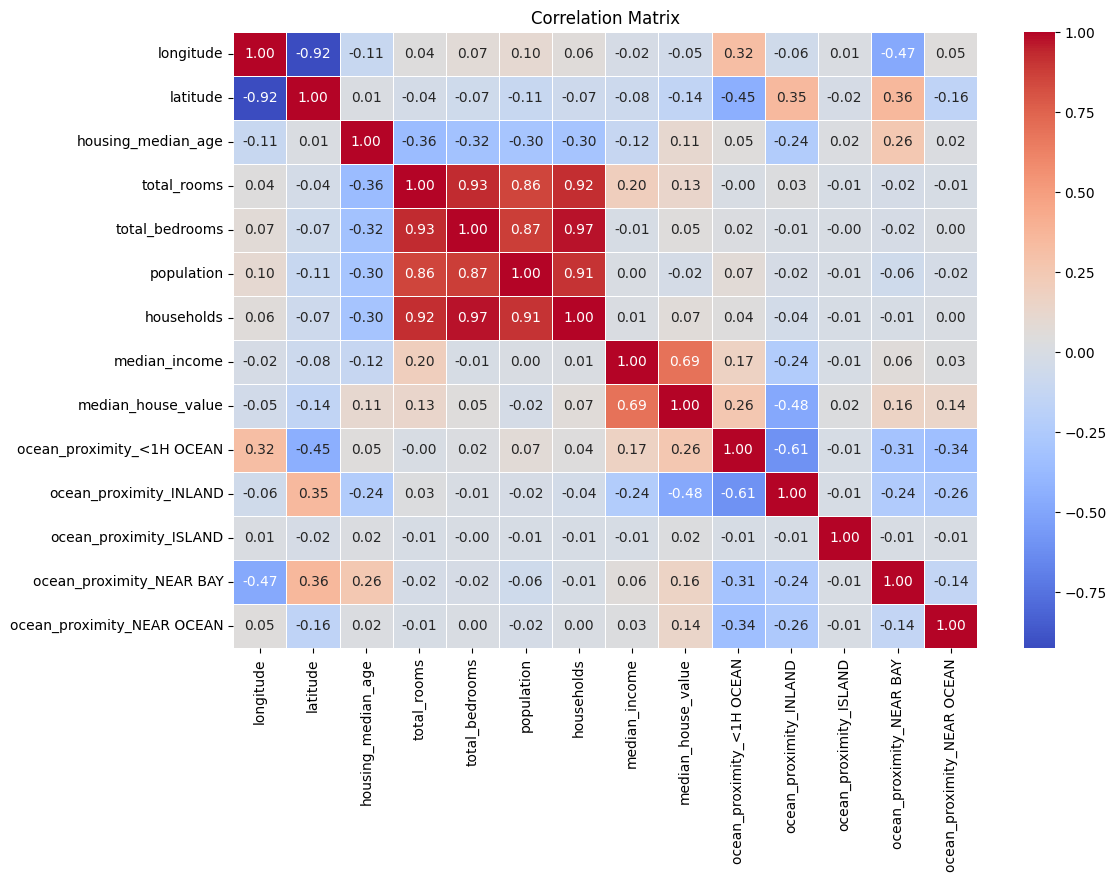

In [9]:
import seaborn as sns
# compute the correlation matrix
correlation_matrix = data[:-1].corr()

# visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Let's check out the distributions of the fields.

It seems that the field with the higher variations, which will dominate in the normalized space, is housing_median_age

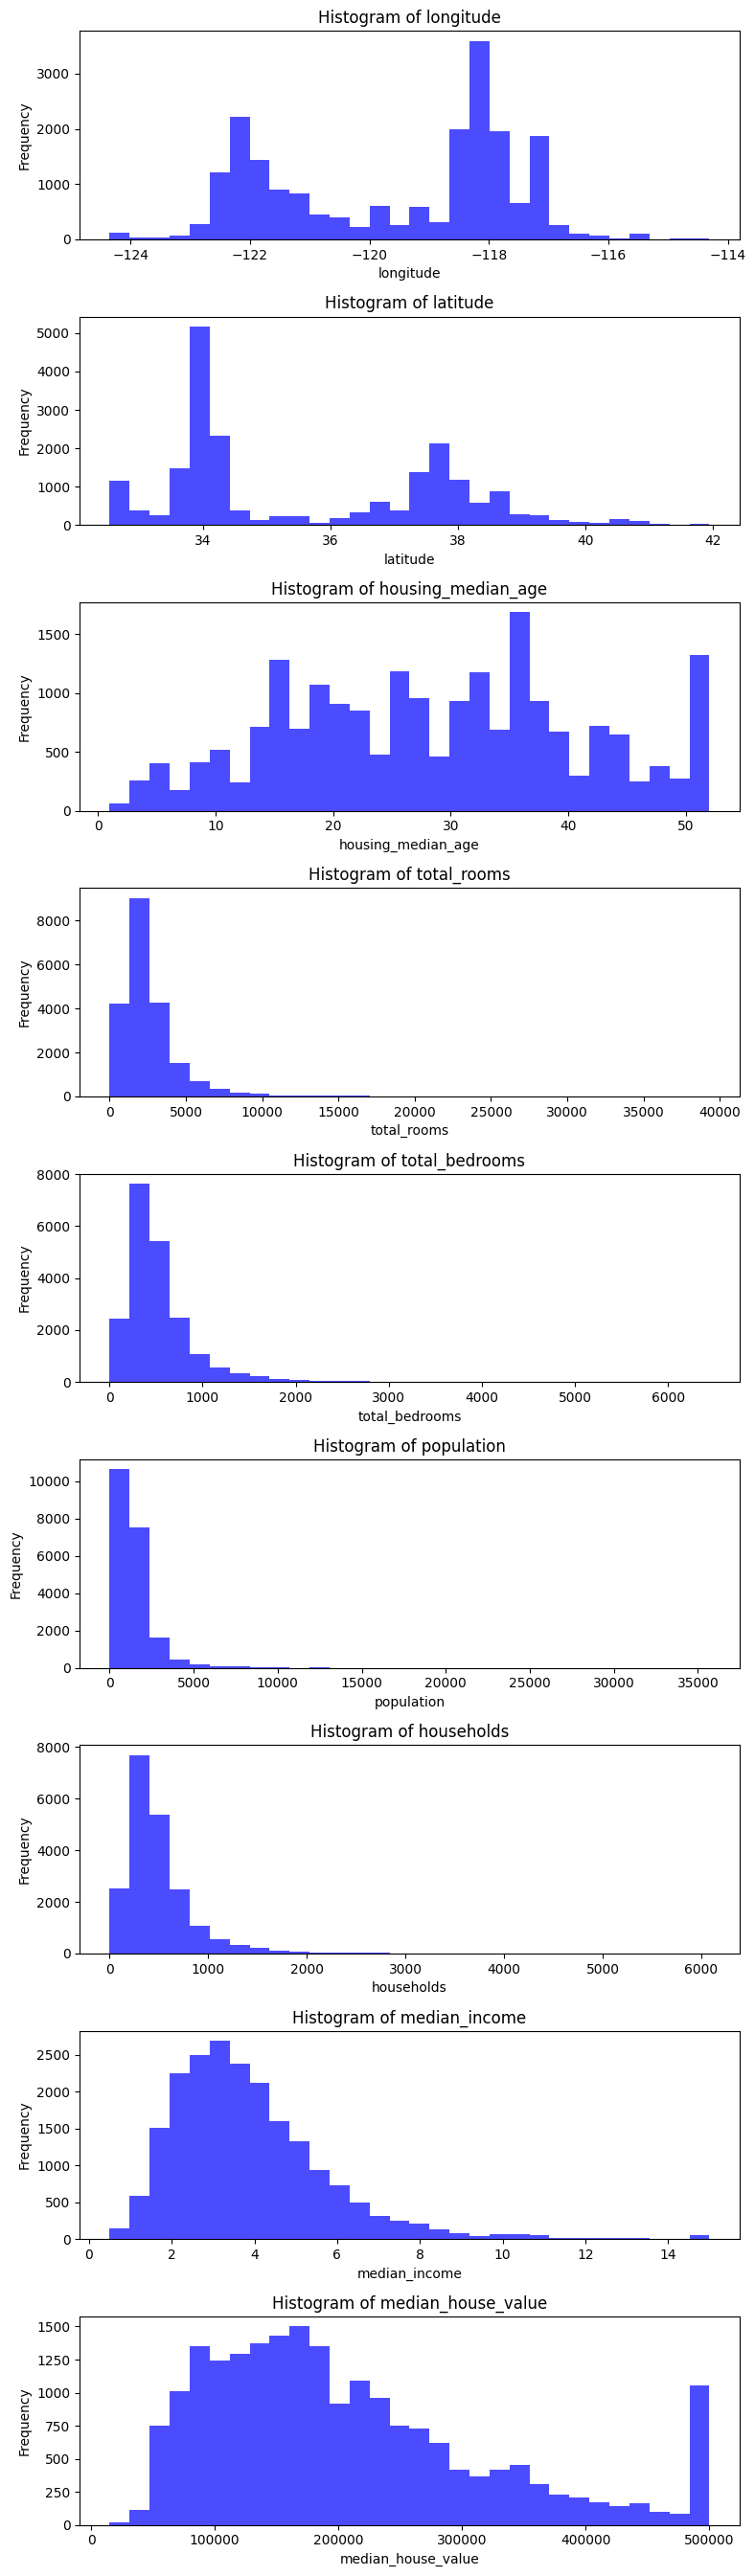

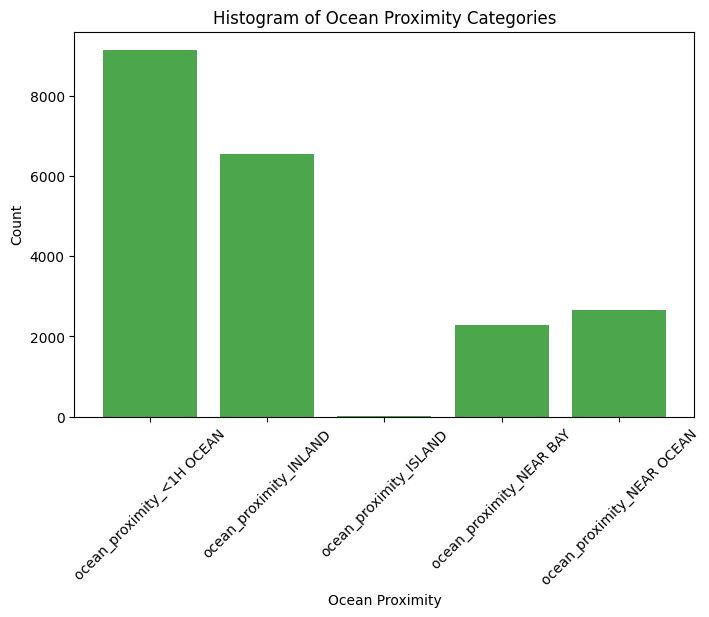

In [10]:
# plot not one-hot-encoded features using histograms
numeric_features = data.columns[:-5]
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(8, len(numeric_features) * 3))

for i, feature in enumerate(numeric_features):
    axes[i].hist(data[feature], bins=30, color='blue', alpha=0.7)
    axes[i].set_title(f"Histogram of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# sum occurrences of each category
ocean_counts = data[ocean_features].sum()

# plot the combined histogram of one-hot-encoded features
plt.figure(figsize=(8, 5))
plt.bar(ocean_counts.index, ocean_counts.values, color='green', alpha=0.7)
plt.title("Histogram of Ocean Proximity Categories")
plt.xlabel("Ocean Proximity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


After simply one-hot encoding, the results on raw data cannot vary that much, but let's first evaluate (as a benchmark) the results of clustering in the normalized features space.

I defined a function which automates the whole experiment as before, visualizing also the results in the original features space. As expected, in the normalized space, the highest dimension (in absolute value) of the first principal component is the one of housing_median_age.
However, this makes clustering in the original space a mess.

K-Means cost: 122225.25152867107
Silhouette Score: 0.26187784615682125
PCA Components:
[[ 7.83063094e-02 -7.86563254e-02 -2.16562860e-01  4.84283519e-01
   4.88248324e-01  4.70179811e-01  4.90669817e-01  5.70670989e-02
   4.70528968e-02  1.87648531e-02 -5.23887385e-03 -6.48780661e-05
  -1.37361322e-02  2.75031006e-04]
 [-6.09843855e-01  6.60815388e-01 -2.09789595e-02  5.85140253e-02
   7.60743207e-02  5.15737802e-02  7.28743751e-02 -2.29982322e-01
  -2.57334905e-01 -1.76682643e-01  1.28633328e-01 -1.73184495e-04
   7.77419809e-02 -2.95194814e-02]]

Explained Variance Ratio:
[0.40401429 0.20844055]


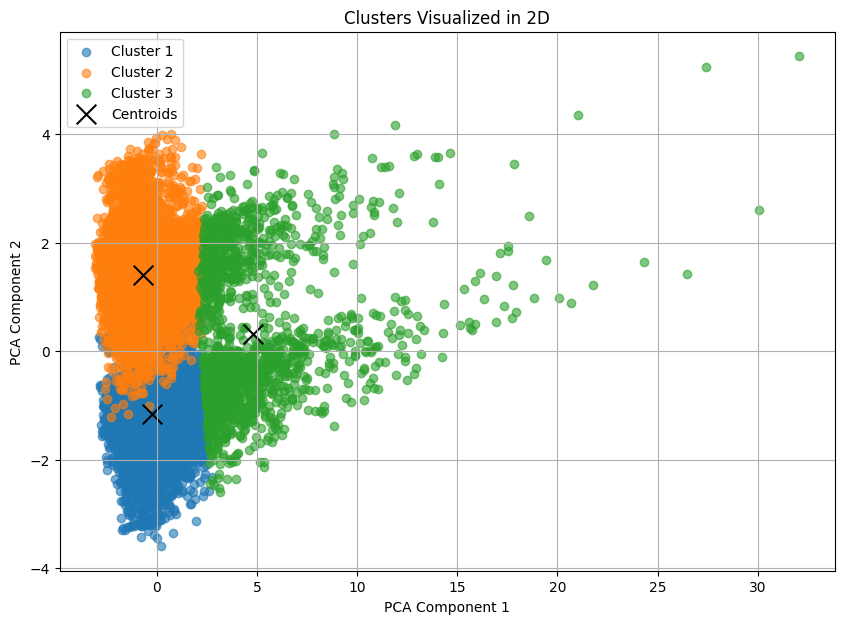

Mutual information between features and clusters: 
 [0.59021379 0.62989879 0.06598633 0.22568782 0.24294075 0.19836238
 0.24303721 0.00946191 0.02772588 0.11048078 0.04936104 0.
 0.08881736 0.00660189] 

PCA Components:
[[-7.98043175e-07 -2.66838390e-06  1.15177844e-05  2.53710308e-03
   1.79836668e-04 -2.41510816e-04  2.18291633e-04  1.13282065e-05
   9.99996712e-01  1.10457292e-06 -1.95576093e-06  3.15792746e-09
   4.36246383e-07  4.11783702e-07]
 [ 5.11747035e-05 -3.34124743e-05 -1.89419230e-03  8.78810816e-01
   1.61747210e-01  4.24104027e-01  1.47162425e-01  6.62151323e-05
  -2.18840647e-03 -2.58728312e-06  1.23701086e-05 -6.82638439e-08
  -6.07875629e-06 -3.63580537e-06]]

Explained Variance Ratio:
[9.99528879e-01 4.48991297e-04]


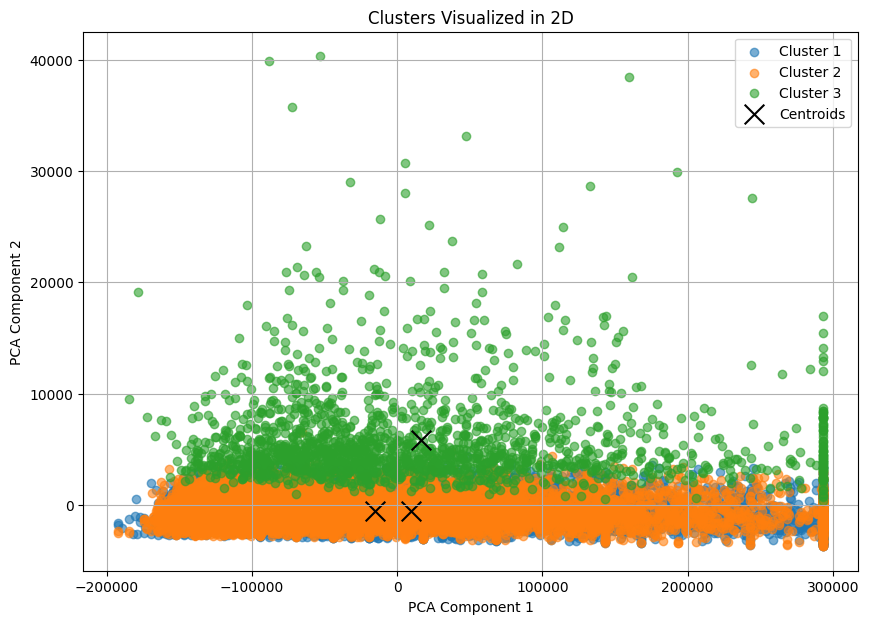

Time needed to run K-Means: 1.8358230590820312e-05


In [11]:
def evaluateKMeansOnNormalizedData(data, not_normalize=[]):
    # rescale data before applying K-Means
    scaler = StandardScaler()
    data_np = data.to_numpy() if isinstance(data, pd.DataFrame) else data

    # create a mask to exclude the indices in not_normalize from normalization
    mask = np.ones(data_np.shape[1], dtype=bool)
    mask[not_normalize] = False

    # rescale the original data into the normalized features space
    data_scaled = scaler.fit_transform(data_np[:, mask])
    data_scaled = np.concatenate((data_scaled, data_np[:, ~mask]), axis=1)

    clusters, centroids, elapsed_time = evaluateKMeans(data_scaled)

    # rescale the centroids into the original features space
    centroids_unscaled = scaler.inverse_transform(centroids[:, mask])
    centroids_unscaled = np.concatenate((centroids_unscaled, centroids[:, ~mask]), axis=1)
    # visualize the results of the clustering
    data_2d, centroids_2d = dataTo2d(data_np, centroids_unscaled)
    scatterplotClusters(data_2d, clusters, centroids_2d)
    return clusters, centroids, elapsed_time, data_scaled

clusters, centroids, elapsed_time, data_scaled = evaluateKMeansOnNormalizedData(data, not_normalize=ocean_feature_indices)
print(f"Time needed to run K-Means: {elapsed_time}")

As expected, on raw data there is no relevant difference.

K-Means cost: 85985081576828.97
Silhouette Score: 0.6290927379295709
PCA Components:
[[-7.98043175e-07 -2.66838390e-06  1.15177844e-05  2.53710308e-03
   1.79836668e-04 -2.41510816e-04  2.18291633e-04  1.13282065e-05
   9.99996712e-01  1.10457292e-06 -1.95576093e-06  3.15792746e-09
   4.36246383e-07  4.11783702e-07]
 [ 5.11747035e-05 -3.34124743e-05 -1.89419230e-03  8.78810816e-01
   1.61747210e-01  4.24104027e-01  1.47162425e-01  6.62151323e-05
  -2.18840647e-03 -2.58728312e-06  1.23701086e-05 -6.82638439e-08
  -6.07875629e-06 -3.63580537e-06]]

Explained Variance Ratio:
[9.99528879e-01 4.48991297e-04]


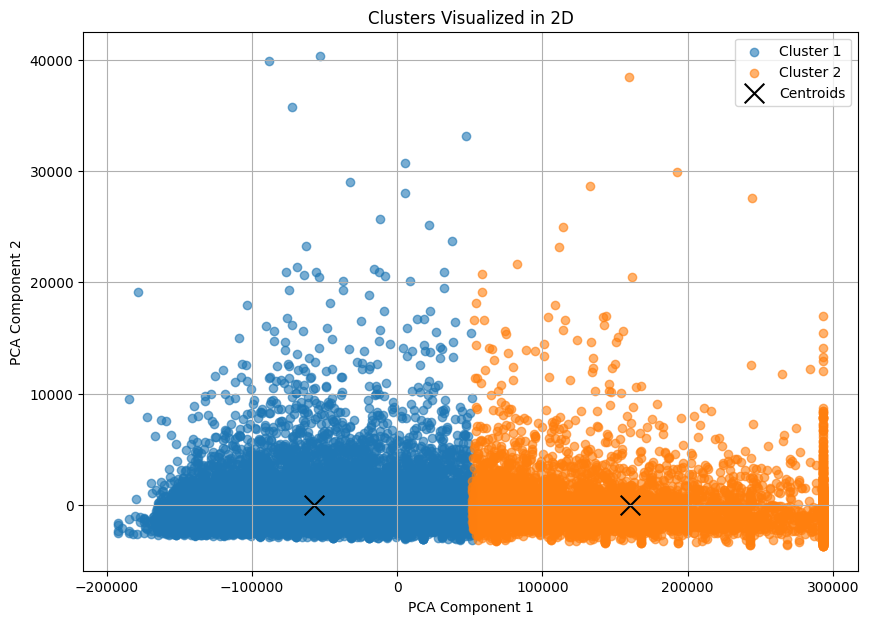

Mutual information between features and clusters: 
 [0.11119813 0.100961   0.01090547 0.01147346 0.00209365 0.0063983
 0.         0.17716001 0.57614824 0.0082237  0.06860183 0.
 0.01157301 0.01127584] 

PCA Components:
[[ 7.83063094e-02 -7.86563254e-02 -2.16562860e-01  4.84283519e-01
   4.88248324e-01  4.70179811e-01  4.90669817e-01  5.70670989e-02
   4.70528968e-02  1.87648531e-02 -5.23887385e-03 -6.48780661e-05
  -1.37361322e-02  2.75031006e-04]
 [-6.09843855e-01  6.60815388e-01 -2.09789595e-02  5.85140253e-02
   7.60743207e-02  5.15737802e-02  7.28743751e-02 -2.29982322e-01
  -2.57334905e-01 -1.76682643e-01  1.28633328e-01 -1.73184495e-04
   7.77419809e-02 -2.95194814e-02]]

Explained Variance Ratio:
[0.40401429 0.20844055]


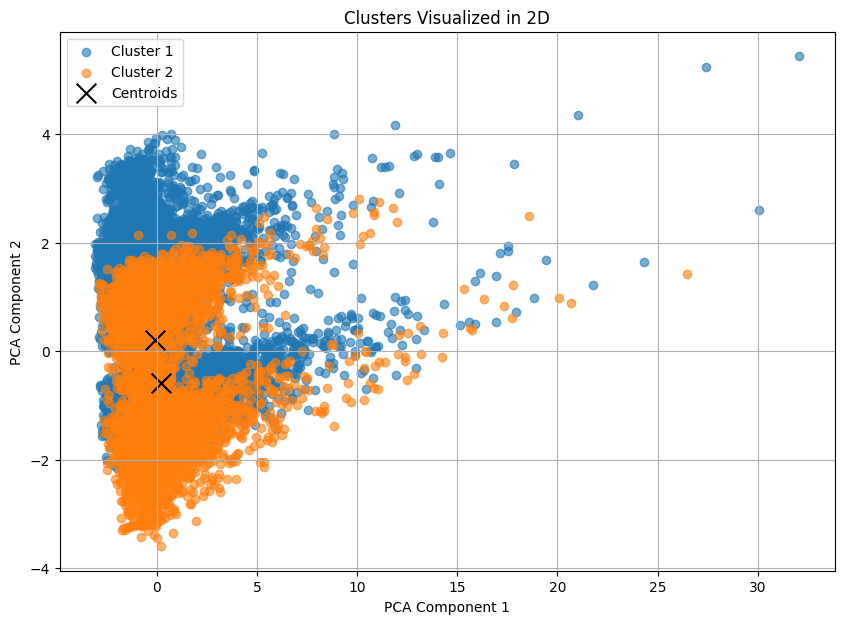

Time needed to run K-Means: 2.384185791015625e-05


In [12]:
clusters, centroids, elapsed_time = evaluateKMeansOnRawData(data, not_normalize=ocean_feature_indices)
print(f"Time needed to run K-Means: {elapsed_time}")

<h2> Experiment 1: Increase feature space </h2>

The first thing we could try is identifying new relevant features that combine the most important ones on which we focused.
Let's try expanding them to see what happens.

I tried to combine features in a way that could provide more meaningful insights to both spaces, for example elevating the housing_median_age to the power 3, to make it more relevant also in the original space and a series of ratios that could expand our data.

In [13]:
# the following information may be relevant
data.loc[:, 'total_not_bedrooms'] = data['total_rooms'] - data['total_bedrooms']

# these ratios (and the final multiplication) involve some of the most important fields
#data.loc[:, 'total_rooms_per_household'] = data['total_rooms'] / data['households']
#data.loc[:, 'income_per_household'] = data['median_income'] / data['households']
data.loc[:, 'median_house_value_per_income'] = data['median_house_value'] / data['median_income']
data.loc[:, 'housing_median_age_per_household'] = data['housing_median_age'] / data['households']
data.loc[:, 'pop_per_household'] = data['population'] / data['households']
data.loc[:, 'rooms_per_household'] = data['total_rooms'] / data['households']
data.loc[:, 'median_house_value_per_age'] = data['median_house_value'] / data['housing_median_age']


data.loc[:, 'median_income_mult_population'] = data['median_income'] * data['population']
#data.loc[:, 'median_income_mult_households'] = data['median_income'] * data['households']

# also rescaled some relevant fields to increase their variance
data.loc[:, 'housing_median_age_pow3'] = data['housing_median_age'] ** 3
#data.loc[:, 'median_income_pow3'] = data['median_income'] ** 3

# please notice that all the following choices were tested and validated with trial and error
# therefore they may not correspond to optimal choices, just the best I found

data

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       ocean_proximity_<1H OCEAN  ...  ocean_proximity_NEAR BAY  \
0                            0.0  ...                       1.0   
1                            0.0  ...                       1.0   
2                            0.0  ...                       1.0   
3                            0.0  ...                       1.0   
4                            0.0  ...                       1.0   
...                          ...  ...                       ...   
20635                        0.0  ...                       0.0   
20636                        0.0  ...                       0.0   
20637                        0.0  ...                       0.0   
20638                        0.0  ...                       0.0   
20639                        0.0  ...                       0.0   

       ocean_proximity_NEAR OCEAN  total_not_bedrooms  \
0                             0.0               751.0   
1                             0.0              5993.0   
2                             0.0              1277.0   
3                             0.0              1039.0   
4                             0.0              1347.0   
...                           ...                 ...   
20635                         0.0              1291.0   
20636                         0.0               547.0   
20637                         0.0              1769.0   
20638                         0.0              1451.0   
20639                         0.0              2169.0   

       median_house_value_per_income  housing_median_age_per_household  \
0                       54365.060299                          0.325397   
1                       43185.486785                          0.018453   
2                       48515.997465                          0.293785   
3                       60480.941327                          0.237443   
4                       88970.932349                          0.200772   
...                              ...                               ...   
20635                   50054.476703                          0.075758   
20636                   30154.881101                          0.157895   
20637                   54294.117647                          0.039261   
20638      

In [14]:
data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        419.266592   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    787.000000    280.000000       2.563400   
50%        438.000000   1166.000000    409.000000       3.534800   
75%        643.250000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  ocean_proximity_<1H OCEAN  ...  \
count        20640.000000               20640.000000  ...   
mean        206855.816909                   0.442636  ...   
std         115395.615874                   0.496710  ...   
min          14999.000000                   0.000000  ...   
25%         119600.000000                   0.000000  ...   
50%         179700.000000                   0.000000  ...   
75%         264725.000000                   1.000000  ...   
max         500001.000000                   1.000000  ...   

       ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  \
count              20640.000000                20640.000000   
mean                   0.110950                    0.128779   
std                    0.314077                    0.334963   
min                    0.000000                    0.000000   
25%                    0.000000                    0.000000   
50%                    0.000000                    0.000000   
75%                    0.000000                    0.000000   
max                    1.000000                    1.000000   

       total_not_bedrooms  median_house_value_per_income  \
count        20640.000000                   2.064000e+04   
mean          2097.892529                   5.650519e+04   
std           1799.709301                   3.235592e+04   
min           -383.870553                   3.576982e+03   
25%           1125.000000                   3.856380e+04   
50%           1681.000000                   4.950018e+04   
75%           2510.000000                   6.587920e+04   
max          33110.000000                   1.000202e+06   

       housing_median_age_per_household  pop_per_household  \
count                      20640.000000       20640.000000   
mean                           0.119909           3.070655   
std                            0.514233          10.386050   
min                            0.000560           0.692308   
25%                            0.035800           2.429741   
50%                            0.068966           2.818116   
75%                            0.119322           3.282261   
max                           52.000000        1243.333333   

       rooms_per_household  median_house_value_per_age  \
count         20640.000000                20640.000000   
mean              5.429000                 9988.846514   
std               2.474173                12427.033755   
min               0.846154                  288.442308   
25%               4.440716                 4214.873916   
50%               5.229129                 6854.692082   
75%               6.052381                11371.547619   
max             141.909091               250000.500000   

       median_in

Let's evaluate the impact of our new features

K-Means cost: 139554875334735.72
Silhouette Score: 0.536982982994045
PCA Components:
[[-8.17224285e-07 -2.65306463e-06  1.33715322e-05  2.36220556e-03
   1.71040946e-04 -2.72862740e-04  2.08827122e-04  1.08738984e-05
   9.89132997e-01  1.09533585e-06 -1.95927182e-06  3.31343011e-09
   4.48600621e-07  4.12021920e-07  2.19116461e-03  1.31336833e-01
   3.74134584e-08 -2.13011839e-06  3.01381975e-06  4.11897110e-02
   1.26805523e-02  4.99863380e-02]
 [-6.35040779e-06  3.26408808e-06  2.87206353e-04 -1.78613862e-02
  -2.66378286e-03 -7.11947124e-03 -2.38352792e-03 -1.37004782e-05
  -7.41683740e-02 -4.77572200e-07 -1.73301266e-06  9.44392051e-09
   2.23804814e-06 -3.69071941e-08 -1.51976033e-02  2.40618923e-01
   1.98125163e-06  2.76925505e-06 -1.15584204e-05 -1.31224692e-01
  -4.82932093e-02  9.57306581e-01]]

Explained Variance Ratio:
[0.84419647 0.09864522]


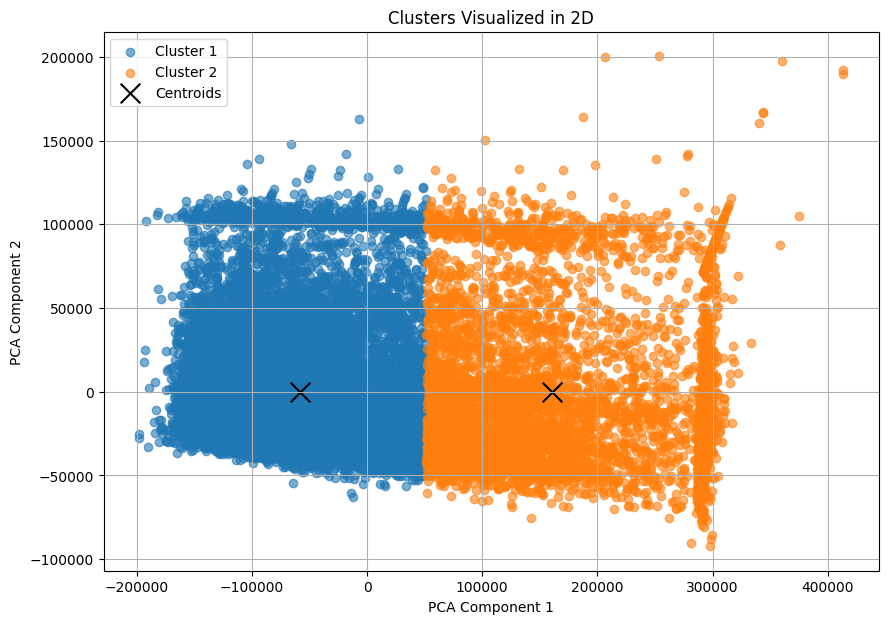

Mutual information between features and clusters: 
 [1.05263993e-01 9.21687690e-02 6.95776108e-03 1.32976570e-02
 9.85067405e-05 6.11730212e-03 0.00000000e+00 1.67729254e-01
 5.64887132e-01 7.69166148e-03 6.84036756e-02 0.00000000e+00
 9.62821551e-03 4.47497507e-03 1.39048257e-02 1.24743320e-01
 0.00000000e+00 4.69862932e-02 5.44358023e-02 2.05288089e-01
 3.20413160e-02 8.24929253e-03] 

PCA Components:
[[ 4.84731945e-02 -4.93327739e-02 -2.09428677e-01  3.95778614e-01
   3.73529953e-01  3.63795787e-01  3.75687752e-01  1.06336743e-01
   7.08223191e-02  3.92745667e-01 -2.89314151e-02 -7.84554043e-02
   1.64606028e-03  4.55107951e-02  1.84063973e-01  3.69555460e-01
  -1.76809237e-01  1.46875677e-02 -3.33158385e-03 -6.74066747e-05
  -1.11552141e-02 -1.33363021e-04]
 [ 1.66147536e-01 -2.60426176e-01 -4.04490883e-03 -5.81270509e-02
  -1.52807153e-01 -1.69558794e-01 -1.53748658e-01  5.20859392e-01
   5.60039200e-01 -3.48633673e-02  1.59711820e-01  6.70150712e-02
   3.70283092e-03  2.20808317e

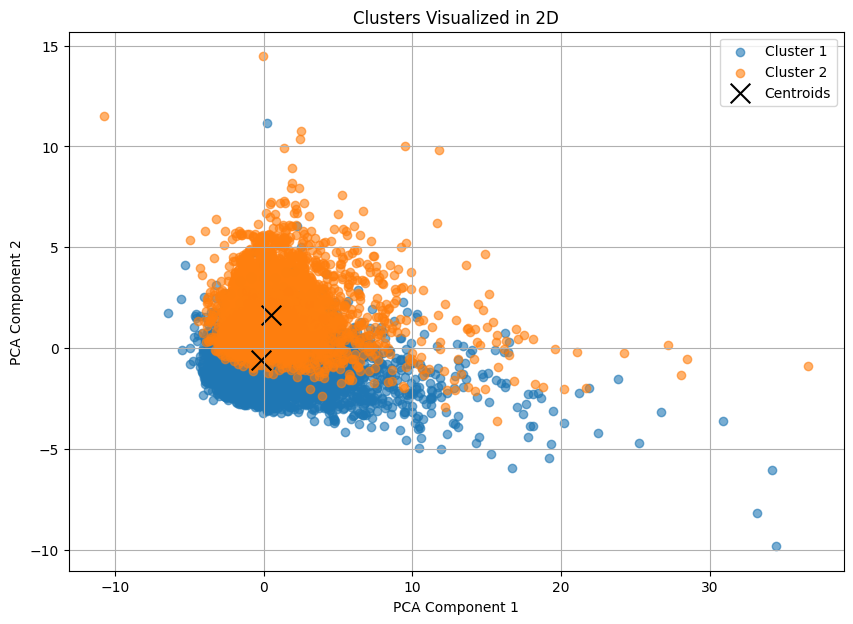

Time needed to run K-Means: 2.8133392333984375e-05


In [15]:
clusters, centroids, elapsed_time = evaluateKMeansOnRawData(data, not_normalize=ocean_feature_indices)
print(f"Time needed to run K-Means: {elapsed_time}")

K-Means cost: 299537.82456242194
Silhouette Score: 0.3824608314806952
PCA Components:
[[ 4.84731945e-02 -4.93327739e-02 -2.09428677e-01  3.95778614e-01
   3.73529953e-01  3.63795787e-01  3.75687752e-01  1.06336743e-01
   7.08223191e-02  3.92745667e-01 -2.89314151e-02 -7.84554043e-02
   1.64606028e-03  4.55107951e-02  1.84063973e-01  3.69555460e-01
  -1.76809237e-01  1.46875677e-02 -3.33158385e-03 -6.74066747e-05
  -1.11552141e-02 -1.33363021e-04]
 [ 1.66147536e-01 -2.60426176e-01 -4.04490883e-03 -5.81270509e-02
  -1.52807153e-01 -1.69558794e-01 -1.53748658e-01  5.20859392e-01
   5.60039200e-01 -3.48633673e-02  1.59711820e-01  6.70150712e-02
   3.70283092e-03  2.20808317e-01  3.43852675e-01  9.22829977e-02
   1.90690445e-02  1.16532620e-01 -1.38188363e-01  1.76528566e-04
  -4.99928781e-03  2.64785025e-02]]

Explained Variance Ratio:
[0.33628392 0.12483934]


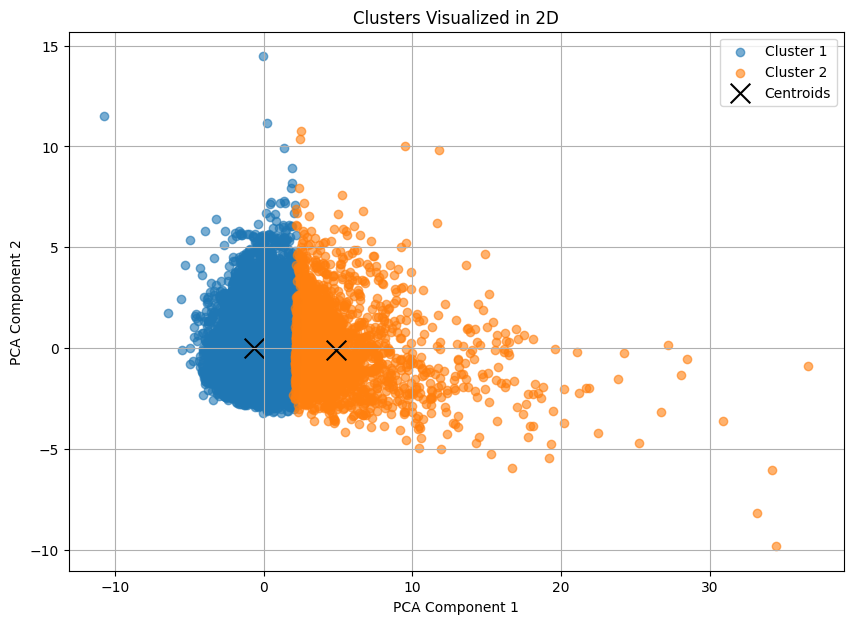

Mutual information between features and clusters: 
 [0.02319322 0.01361671 0.07049911 0.29228789 0.23072218 0.20975936
 0.23297924 0.02618764 0.01468437 0.27876199 0.00912787 0.20394817
 0.00259353 0.0103943  0.07725046 0.21623761 0.07096193 0.
 0.00330391 0.         0.00125014 0.00302552] 

PCA Components:
[[-8.17224285e-07 -2.65306463e-06  1.33715322e-05  2.36220556e-03
   1.71040946e-04 -2.72862740e-04  2.08827122e-04  1.08738984e-05
   9.89132997e-01  1.09533585e-06 -1.95927182e-06  3.31343011e-09
   4.48600621e-07  4.12021920e-07  2.19116461e-03  1.31336833e-01
   3.74134584e-08 -2.13011839e-06  3.01381975e-06  4.11897110e-02
   1.26805523e-02  4.99863380e-02]
 [-6.35040779e-06  3.26408808e-06  2.87206353e-04 -1.78613862e-02
  -2.66378286e-03 -7.11947124e-03 -2.38352792e-03 -1.37004782e-05
  -7.41683740e-02 -4.77572200e-07 -1.73301266e-06  9.44392051e-09
   2.23804814e-06 -3.69071941e-08 -1.51976033e-02  2.40618923e-01
   1.98125163e-06  2.76925505e-06 -1.15584204e-05 -1.31224692e

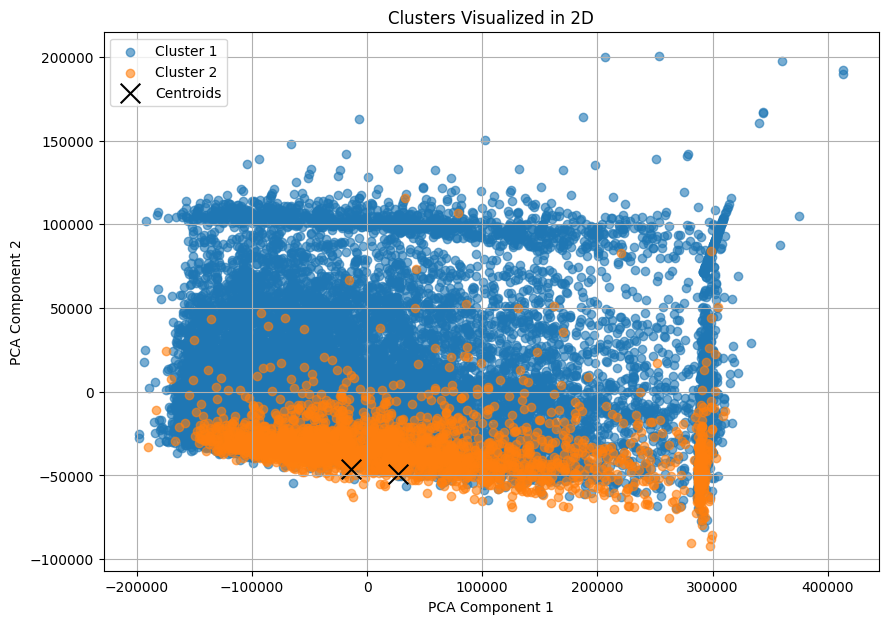

Time needed to run K-Means: 2.5033950805664062e-05


In [16]:
clusters, centroids, elapsed_time, data_scaled_augmented = evaluateKMeansOnNormalizedData(data, not_normalize=ocean_feature_indices)
print(f"Time needed to run K-Means: {elapsed_time}")

<h2> Error analysis </h2>

While clustering on the raw data seems to have slightly improved, clustering in the original space seems to have no significant improvement, there seems to be too much noise, which we should have removed in advance.
In particular, both clustering, when transformed into the rescaled space, significantly overlap, despite I succesfully increased the separation of the data.
For the moment, let's try to reduce the noise using dimensionality reduction techniques.


<h2> Experiment 2: Reduce dimensionality </h2>

To try to reduce noise, we could reduce the number of dimensions of the dataset.
There are two techniques that I will test: PCA and Random Projection.

The first technique, already used above for K-Means visualization, is used to preserve the vairance of the original feature space.

The second technique, instead, preserves the geometry of the feature space. It means that it preserves the pairwise distances between points (Johnson-Lindenstrauss Lemma).

<h4>PCA</h4>

I used the elbow method to determine how many dimensions to keep.

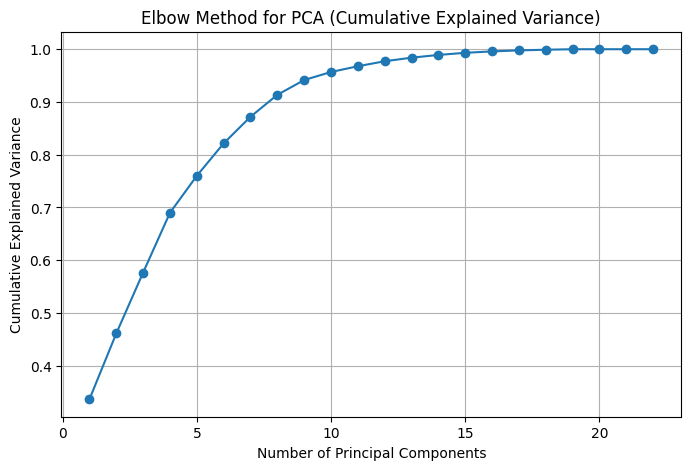

Cumulative explained variance: [0.33628392 0.46112327 0.5765125  0.68989135 0.75995604 0.82153971
 0.87188799 0.91355017 0.94154059 0.95683925 0.96771256 0.97720653
 0.98394795 0.98915198 0.9932162  0.99586416 0.99779418 0.99903172
 0.99998294 1.         1.         1.        ]
PCA Components: [[ 4.84731945e-02 -4.93327739e-02 -2.09428677e-01  3.95778614e-01
   3.73529953e-01  3.63795787e-01  3.75687752e-01  1.06336743e-01
   7.08223191e-02  3.92745667e-01 -2.89314151e-02 -7.84554043e-02
   1.64606028e-03  4.55107951e-02  1.84063973e-01  3.69555460e-01
  -1.76809237e-01  1.46875677e-02 -3.33158385e-03 -6.74066747e-05
  -1.11552141e-02 -1.33363021e-04]
 [ 1.66147536e-01 -2.60426176e-01 -4.04490883e-03 -5.81270509e-02
  -1.52807153e-01 -1.69558794e-01 -1.53748658e-01  5.20859392e-01
   5.60039200e-01 -3.48633673e-02  1.59711820e-01  6.70150712e-02
   3.70283092e-03  2.20808317e-01  3.43852675e-01  9.22829977e-02
   1.90690445e-02  1.16532620e-01 -1.38188363e-01  1.76528566e-04
  -4.999287

In [17]:
def elbowPCA(data):
    # apply PCA to find the normalized dimensions with higher variance
    pca = PCA()
    pca.fit(data)

    # plot the explained variance ratio for each principal component
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o')
    plt.title('Elbow Method for PCA (Cumulative Explained Variance)')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # print the cumulative explained variance for reference
    print(f"Cumulative explained variance: {cumulative_variance}")
    print(f"PCA Components: {pca.components_}")

elbowPCA(data_scaled_augmented)

In [18]:
pca_dims = 10  # number of dimensions to project to, chosen using the elbow method
pca = PCA(n_components=pca_dims)
data_reduced = pca.fit_transform(data)
pca = PCA(n_components=pca_dims)
data_reduced_scaled = pca.fit_transform(data_scaled_augmented)
print(f"Projecting the datasets to {pca_dims} dimensions with PCA")

Projecting the datasets to 10 dimensions with PCA


K-Means cost: 139554874768362.0
Silhouette Score: 0.5369829842382392
PCA Components:
[[ 1.00000000e+00  2.47516223e-18 -1.72499768e-16 -2.16780692e-17
  -2.20044642e-17  1.75063329e-17  1.18386990e-17  8.85473989e-19
  -1.39705993e-18 -2.67781773e-18]
 [-2.47516223e-18  1.00000000e+00 -1.44328993e-15 -1.94289029e-16
   1.11022302e-16 -2.63677968e-16 -1.94289029e-16 -4.85722573e-17
   3.46944695e-17  3.46944695e-17]]

Explained Variance Ratio:
[0.84419648 0.09864522]


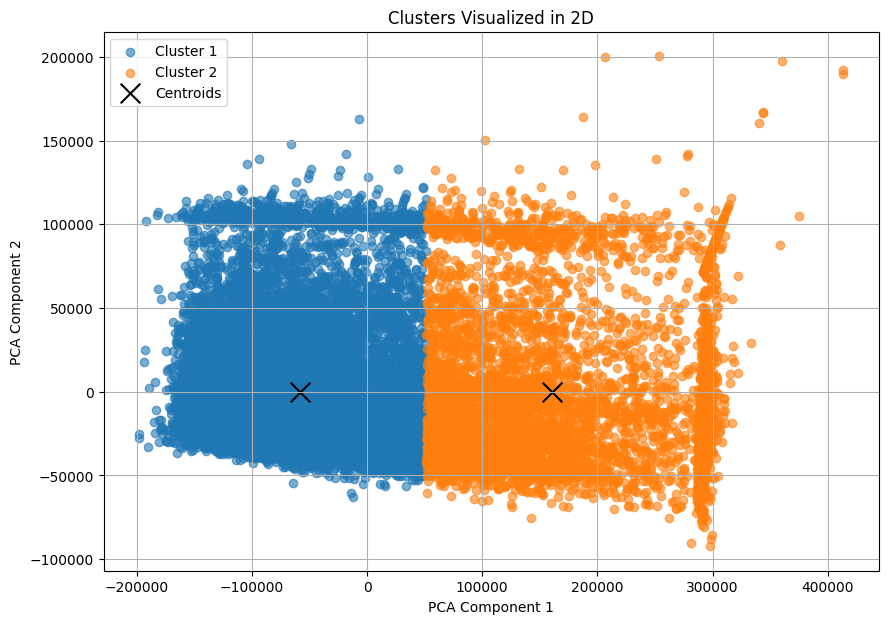

Mutual information between features and clusters: 
 [0.57799055 0.06896164 0.05290532 0.15458439 0.0193445  0.02561455
 0.02596857 0.01926308 0.         0.02761443] 

Time needed to run K-Means: 1.9311904907226562e-05


In [19]:
clusters, centroids, elapsed_time = evaluateKMeans(data_reduced)
print(f"Time needed to run K-Means: {elapsed_time}")

K-Means cost: 283801.08292920364
Silhouette Score: 0.387060811113513
PCA Components:
[[ 1.00000000e+00 -2.92225222e-16 -1.88547641e-16 -1.59333443e-16
   2.30582506e-16  5.75291116e-17  8.06765433e-18  7.70184695e-18
  -7.72473766e-17 -4.10068969e-17]
 [ 2.92225222e-16  1.00000000e+00 -9.04831765e-15 -1.57096558e-14
   1.22124533e-15  4.44089210e-16 -4.51028104e-17 -1.66533454e-16
  -4.99600361e-16  1.11022302e-16]]

Explained Variance Ratio:
[0.3514529  0.13047055]


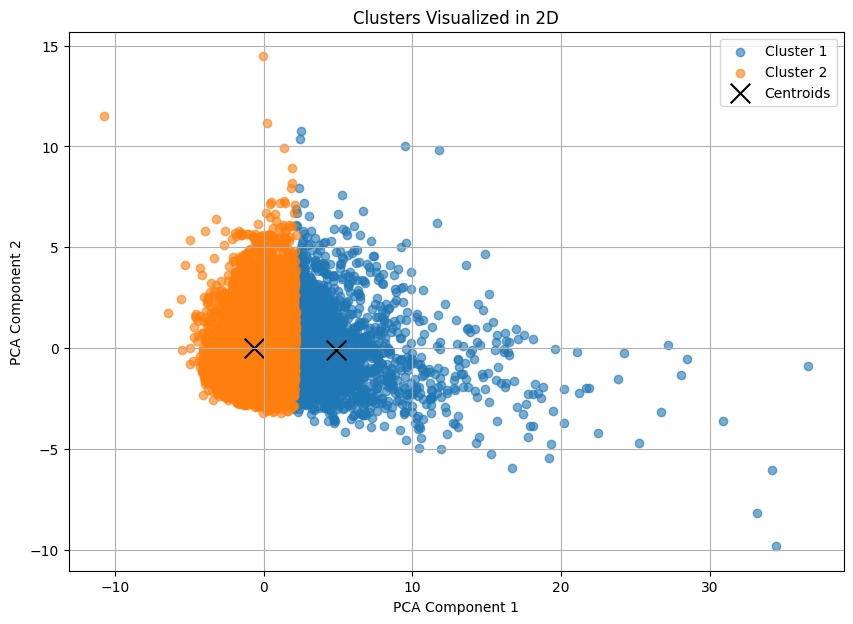

Mutual information between features and clusters: 
 [3.57388033e-01 1.63603313e-02 3.86919777e-03 5.27331666e-03
 3.43191208e-04 7.18757350e-03 2.15152503e-02 3.17892139e-03
 3.15831041e-02 4.25136154e-03] 

Time needed to run K-Means: 1.7881393432617188e-05


In [20]:
clusters, centroids, elapsed_time = evaluateKMeans(data_reduced_scaled)
print(f"Time needed to run K-Means: {elapsed_time}")

PCA does not seem to affect the clusters at all and they look like before applying it.

<h4>Gaussian Random Projection</h4>

In [21]:
grp = GaussianRandomProjection(n_components=pca_dims, random_state=seed)
data_reduced = grp.fit_transform(data)
grp = GaussianRandomProjection(n_components=pca_dims, random_state=seed)
data_reduced_scaled = grp.fit_transform(data_scaled_augmented)
print(f"Projecting the datasets to {grp.components_.shape[0]} dimensions with Random Projection")


Projecting the datasets to 10 dimensions with Random Projection


K-Means cost: 166780534379833.97
Silhouette Score: 0.522520771651181
PCA Components:
[[-0.04216122  0.35275926 -0.01710728  0.29334364  0.1906249   0.3676104
  -0.04585431 -0.1332187   0.59783924 -0.48857275]
 [-0.27180276  0.0460105  -0.1798469   0.71044233  0.21845595 -0.18235714
  -0.25696041  0.30983974 -0.37141872 -0.07729665]]

Explained Variance Ratio:
[0.85162505 0.11790622]


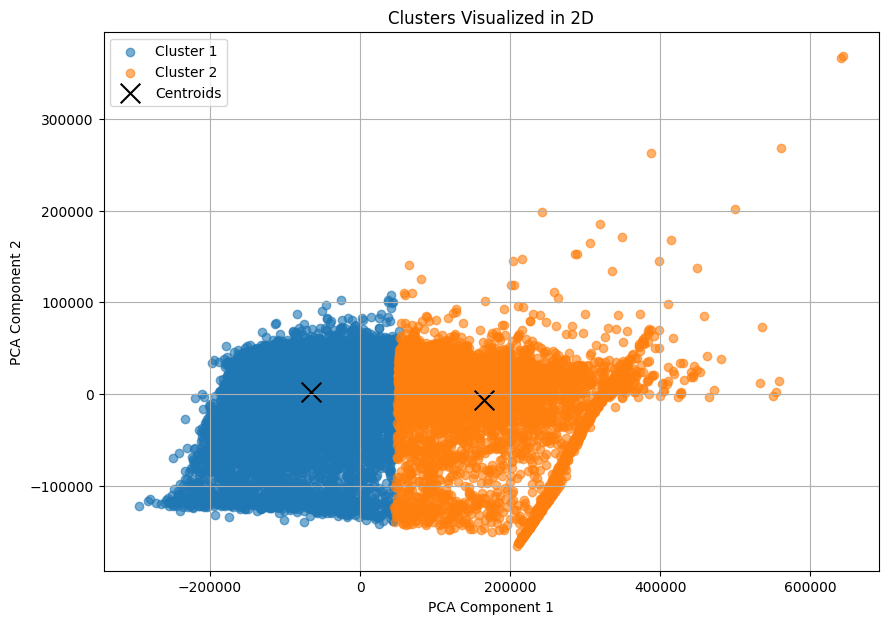

Mutual information between features and clusters: 
 [0.02490281 0.53446746 0.05677409 0.29215403 0.36864937 0.51042945
 0.12020074 0.26919714 0.51088215 0.56475521] 



In [22]:
clusters, centroids, elapsed_time = evaluateKMeans(data_reduced)


K-Means cost: 265743.7219840862
Silhouette Score: 0.4037793688506171
PCA Components:
[[ 0.22132907  0.00761917 -0.20048555  0.21422363  0.6569102   0.34895984
  -0.03739656  0.15881428 -0.48825943 -0.21574856]
 [ 0.65236003 -0.21260967  0.24296808  0.19075703  0.21880599 -0.10022845
   0.27123754  0.15433534  0.3566195   0.38899012]]

Explained Variance Ratio:
[0.31254158 0.28045615]


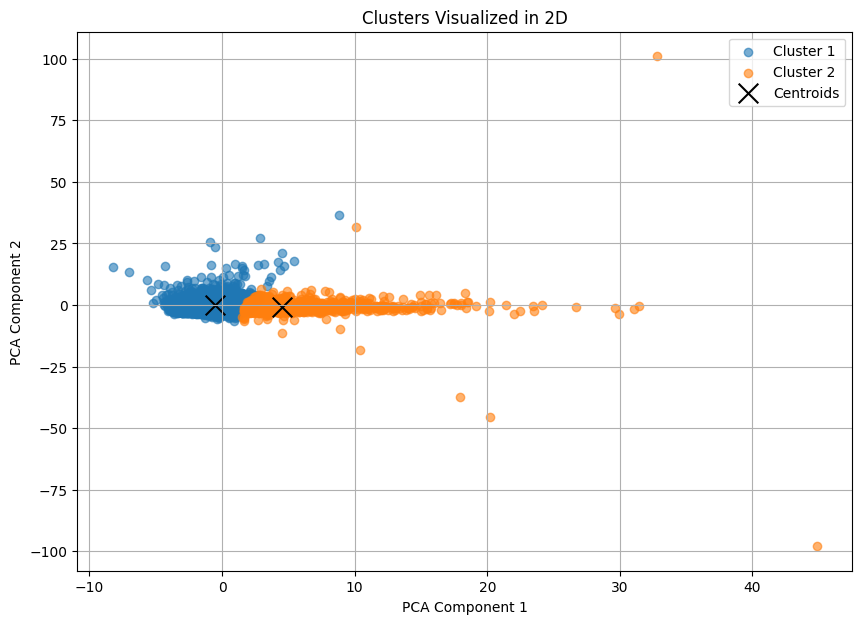

Mutual information between features and clusters: 
 [0.01630244 0.01531692 0.13035809 0.00359193 0.18206293 0.13592342
 0.00484325 0.09668455 0.17814216 0.13927287] 

Time needed to run K-Means: 1.9550323486328125e-05


In [23]:
clusters, centroids, elapsed_time = evaluateKMeans(data_reduced_scaled)
print(f"Time needed to run K-Means: {elapsed_time}")

Random Projection causes a considerable distortion, especially in the normalized feature space, increasing the noise already present in the input data.

<h2> Error Analysis </h2>

Dimensionality reduction techniques don't seem to have succesfully reduced noise. This may be caused by the presence of noisy features in the original data. Moreover, we lost the possibility to represent data in the opposite features space, to validate the clustering generalization in both unscaled and normalized feature spaces.

Moreover, the distortion provoked by random projection is huge and noise is significantly increased in the normalized space by this transformation.

Therefore I will now exclude some features in order to improve the representation of our data.

Hence, let's start dropping all the previously added features.

In [24]:
data = data.drop(columns=data.columns[14:])
data

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
0                            0.0                     0.0   
1                            0.0                     0.0   
2                            0.0                     0.0   
3                            0.0                     0.0   
4                            0.0                     0.0   
...                          ...                     ...   
20635                        0.0                     1.0   
20636                        0.0                     1.0   
20637                        0.0                     1.0   
20638                        0.0                     1.0   
20639                        0.0                     1.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
0                         0.0                       1.0   
1                         0.0                       1.0   
2                         0.0                       1.0   
3                         0.0                       1.0   
4                         0.0                       1.0   
...                       ...                       ...   
20635                     0.0                       0.0   
20636                     0.0                       0.0   
20637                     0.0                       0.0   
20638                     0.0                       0.0   
20639                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  
...                           ...  
20635                         0.0  
20636                         0.0  
20637                         0.0  
20638                         0.0  
20639                         0.0  

[20640 rows x 14 columns]

<h2> Experiment 3: Dimensionality reduction by noisy features removal</h2>

First of all, I checked which features could be good candidates for removal, dominating the principal components of the normalized features space, despite not being quite relevant for both spaces.





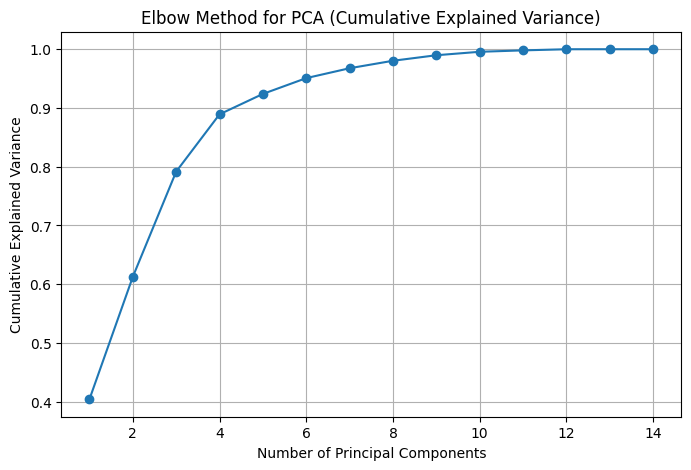

Cumulative explained variance: [0.40401429 0.61245483 0.79161398 0.88916061 0.92388038 0.95079949
 0.96763121 0.98034464 0.98975242 0.99563744 0.99803371 0.99996882
 1.         1.        ]
PCA Components: [[ 7.83063094e-02 -7.86563254e-02 -2.16562860e-01  4.84283519e-01
   4.88248324e-01  4.70179811e-01  4.90669817e-01  5.70670989e-02
   4.70528968e-02  1.87648531e-02 -5.23887385e-03 -6.48780661e-05
  -1.37361322e-02  2.75031006e-04]
 [-6.09843855e-01  6.60815388e-01 -2.09789595e-02  5.85140253e-02
   7.60743207e-02  5.15737802e-02  7.28743751e-02 -2.29982322e-01
  -2.57334905e-01 -1.76682643e-01  1.28633328e-01 -1.73184495e-04
   7.77419809e-02 -2.95194814e-02]
 [-3.26127664e-01  1.99039536e-01  7.23708945e-02  8.79766166e-02
  -2.92275731e-02 -6.74191906e-02 -1.28416694e-02  6.28226984e-01
   6.46747725e-01  3.38281074e-02 -1.24226601e-01  4.22079346e-05
   7.57688921e-02  1.45873939e-02]
 [-6.32206227e-02 -7.48458628e-02  8.98785831e-01  1.54684957e-02
   1.26975447e-01  1.26968864e

In [25]:
elbowPCA(data_scaled)

I Identified three possible candidates for removal:


*   Latitude and longitude
*   Ocean proximity features

I will perform an ablation study, remvoing these features in the same order as above and checking differences in clustering.
Let's first remove latitude and longitude.

I will replace them with a more meaningful representation of the same information: the distance from the center of the households (the mean values of latitude and longitude).


In [26]:
center = {'latitude': data['latitude'].mean(), 'longitude': data['longitude'].mean()}
data['distance_from_center'] = np.sqrt((data['latitude'] - center['latitude'])**2 +
                                       (data['longitude'] - center['longitude'])**2)

data = data.drop(columns=data.columns[:2])
ocean_feature_indices = [data.columns.get_loc(col) for col in ocean_features]
data

housing_median_age  total_rooms  total_bedrooms  population  \
0                    41.0        880.0           129.0       322.0   
1                    21.0       7099.0          1106.0      2401.0   
2                    52.0       1467.0           190.0       496.0   
3                    52.0       1274.0           235.0       558.0   
4                    52.0       1627.0           280.0       565.0   
...                   ...          ...             ...         ...   
20635                25.0       1665.0           374.0       845.0   
20636                18.0        697.0           150.0       356.0   
20637                17.0       2254.0           485.0      1007.0   
20638                18.0       1860.0           409.0       741.0   
20639                16.0       2785.0           616.0      1387.0   

       households  median_income  median_house_value  \
0           126.0         8.3252            452600.0   
1          1138.0         8.3014            358500.0   
2           177.0         7.2574            352100.0   
3           219.0         5.6431            341300.0   
4           259.0         3.8462            342200.0   
...           ...            ...                 ...   
20635       330.0         1.5603             78100.0   
20636       114.0         2.5568             77100.0   
20637       433.0         1.7000             92300.0   
20638       349.0         1.8672             84700.0   
20639       530.0         2.3886             89400.0   

       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
0                            0.0                     0.0   
1                            0.0                     0.0   
2                            0.0                     0.0   
3                            0.0                     0.0   
4                            0.0                     0.0   
...                          ...                     ...   
20635                        0.0                     1.0   
20636                        0.0                     1.0   
20637                        0.0                     1.0   
20638                        0.0                     1.0   
20639                        0.0                     1.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
0                         0.0                       1.0   
1                         0.0                       1.0   
2                         0.0                       1.0   
3                         0.0                       1.0   
4                         0.0                       1.0   
...                       ...                       ...   
20635                     0.0                       0.0   
20636                     0.0                       0.0   
20637                     0.0                       0.0   
20638                     0.0                       0.0   
20639                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  distance_from_center  
0                             0.0              3.483001  
1                             0.0              3.462466  
2                             0.0              3.471400  
3                             0.0              3.479098  
4                             0.0              3.479098  
...                           ...                   ...  
20635                         0.0              4.137568  
20636                         0.0              4.192350  
20637                         0.0              4.141175  
20638                         0.0              4.182032  
20639                         0.0              4.094334  

[20640 rows x 13 columns]

K-Means cost: 85985081422140.11
Silhouette Score: 0.6290927396131589
PCA Components:
[[ 1.15177844e-05  2.53710308e-03  1.79836668e-04 -2.41510816e-04
   2.18291633e-04  1.13282065e-05  9.99996712e-01  1.10457292e-06
  -1.95576093e-06  3.15792746e-09  4.36246383e-07  4.11783702e-07
  -6.14768343e-07]
 [-1.89419228e-03  8.78810819e-01  1.61747210e-01  4.24104025e-01
   1.47162425e-01  6.62151327e-05 -2.18840643e-03 -2.58728847e-06
   1.23701109e-05 -6.82638495e-08 -6.07875234e-06 -3.63580623e-06
   2.42459266e-06]]

Explained Variance Ratio:
[9.99528880e-01 4.48991296e-04]


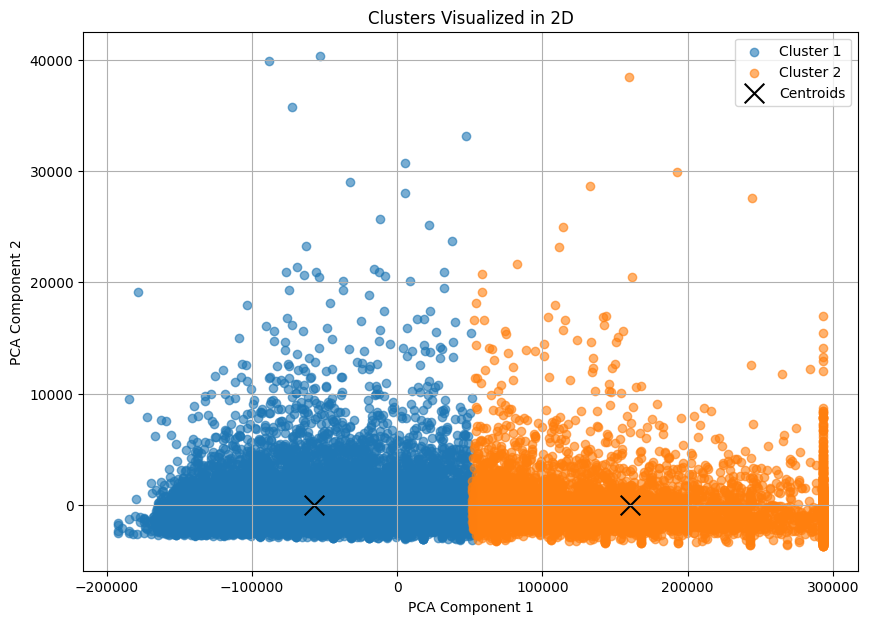

Mutual information between features and clusters: 
 [5.50505649e-03 1.37294569e-02 3.43754674e-03 2.06358562e-04
 4.37055817e-03 1.76393143e-01 5.76142396e-01 5.48201139e-03
 6.78772207e-02 0.00000000e+00 8.68856777e-03 7.44964367e-03
 1.67897464e-01] 

PCA Components:
[[-2.16584657e-01  4.88658645e-01  4.91742011e-01  4.72026872e-01
   4.94355604e-01  5.51773942e-02  4.42434859e-02 -1.01464923e-02
   1.07401390e-02 -7.53862145e-04 -7.38504606e-05 -8.61293555e-03
  -1.29949087e-03]
 [ 6.99081831e-02  5.67515899e-02 -5.58421635e-02 -7.53007883e-02
  -3.92123177e-02  6.67508643e-01  6.93726009e-01 -1.12999505e-01
   1.17327627e-01 -1.64550023e-01  1.09426011e-04  2.68106108e-02
   2.03023597e-02]]

Explained Variance Ratio:
[0.4478278  0.20386556]


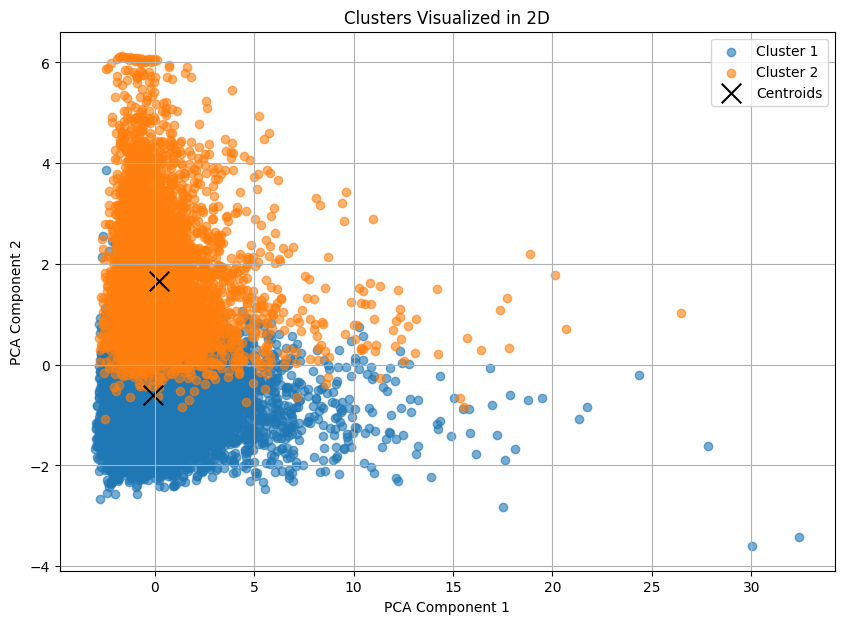

Time needed to run K-Means: 2.3603439331054688e-05


In [27]:
clusters, centroids, elapsed_time = evaluateKMeansOnRawData(data, not_normalize=ocean_feature_indices)
print(f"Time needed to run K-Means: {elapsed_time}")

K-Means cost: 135407.9794770015
Silhouette Score: 0.4046531183984409
PCA Components:
[[-2.16584657e-01  4.88658645e-01  4.91742011e-01  4.72026872e-01
   4.94355604e-01  5.51773942e-02  4.42434859e-02 -1.01464923e-02
   1.07401390e-02 -7.53862145e-04 -7.38504606e-05 -8.61293555e-03
  -1.29949087e-03]
 [ 6.99081831e-02  5.67515899e-02 -5.58421635e-02 -7.53007883e-02
  -3.92123177e-02  6.67508643e-01  6.93726009e-01 -1.12999505e-01
   1.17327627e-01 -1.64550023e-01  1.09426011e-04  2.68106108e-02
   2.03023597e-02]]

Explained Variance Ratio:
[0.4478278  0.20386556]


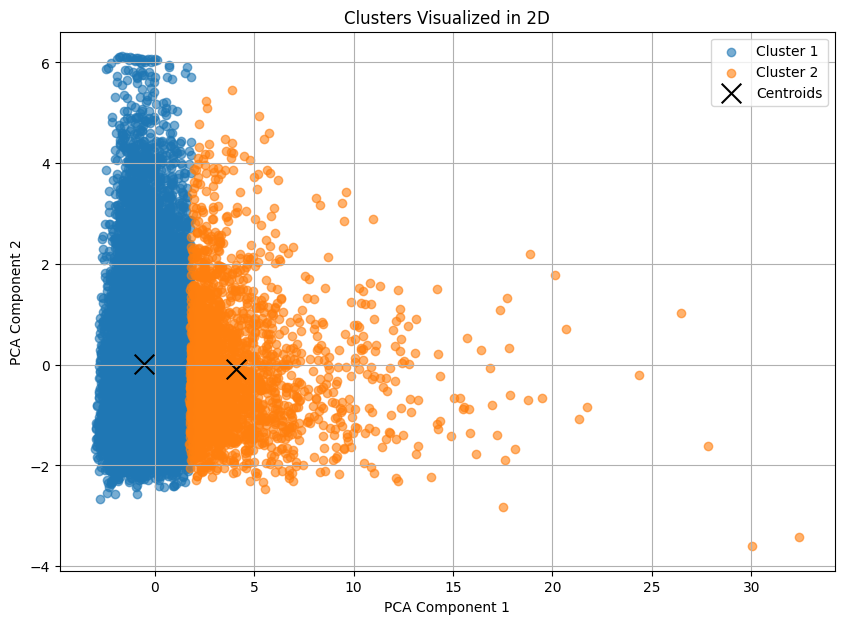

Mutual information between features and clusters: 
 [0.05741427 0.26483759 0.28605592 0.23610217 0.29041187 0.01318811
 0.00818877 0.02658003 0.00178911 0.00104501 0.         0.
 0.        ] 

PCA Components:
[[ 1.15177844e-05  2.53710308e-03  1.79836668e-04 -2.41510816e-04
   2.18291633e-04  1.13282065e-05  9.99996712e-01  1.10457292e-06
  -1.95576093e-06  3.15792746e-09  4.36246383e-07  4.11783702e-07
  -6.14768343e-07]
 [-1.89419228e-03  8.78810819e-01  1.61747210e-01  4.24104025e-01
   1.47162425e-01  6.62151327e-05 -2.18840643e-03 -2.58728847e-06
   1.23701109e-05 -6.82638495e-08 -6.07875234e-06 -3.63580623e-06
   2.42459266e-06]]

Explained Variance Ratio:
[9.99528880e-01 4.48991296e-04]


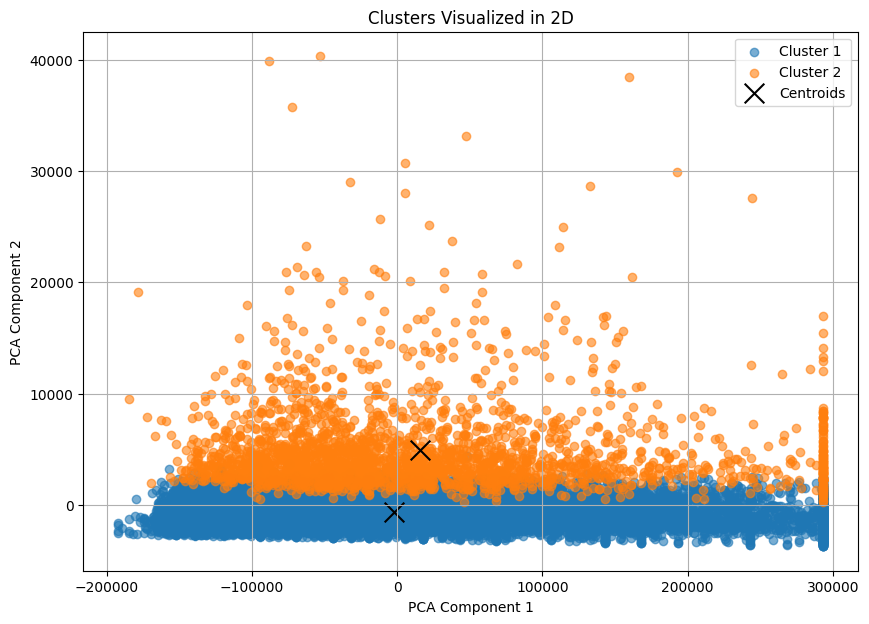

Time needed to run K-Means: 1.7404556274414062e-05


In [28]:
clusters, centroids, elapsed_time, _ = evaluateKMeansOnNormalizedData(data, not_normalize=ocean_feature_indices)
print(f"Time needed to run K-Means: {elapsed_time}")

Removing these features enhanced clustering especially in the normalized space, while making it more appropriate also in the raw features space. Now the clustering in the normalized space seems to make sense also in the original space, clearly separating the data.

Moreover, the two clustering techniques clearly separate the data on different dimensions.

Let's try removing also the ocean proximity one-hot encoded features.

In [29]:
data = data.drop(columns=data.columns[ocean_feature_indices])
data

housing_median_age  total_rooms  total_bedrooms  population  \
0                    41.0        880.0           129.0       322.0   
1                    21.0       7099.0          1106.0      2401.0   
2                    52.0       1467.0           190.0       496.0   
3                    52.0       1274.0           235.0       558.0   
4                    52.0       1627.0           280.0       565.0   
...                   ...          ...             ...         ...   
20635                25.0       1665.0           374.0       845.0   
20636                18.0        697.0           150.0       356.0   
20637                17.0       2254.0           485.0      1007.0   
20638                18.0       1860.0           409.0       741.0   
20639                16.0       2785.0           616.0      1387.0   

       households  median_income  median_house_value  distance_from_center  
0           126.0         8.3252            452600.0              3.483001  
1          1138.0         8.3014            358500.0              3.462466  
2           177.0         7.2574            352100.0              3.471400  
3           219.0         5.6431            341300.0              3.479098  
4           259.0         3.8462            342200.0              3.479098  
...           ...            ...                 ...                   ...  
20635       330.0         1.5603             78100.0              4.137568  
20636       114.0         2.5568             77100.0              4.192350  
20637       433.0         1.7000             92300.0              4.141175  
20638       349.0         1.8672             84700.0              4.182032  
20639       530.0         2.3886             89400.0              4.094334  

[20640 rows x 8 columns]

K-Means cost: 85985081408878.28
Silhouette Score: 0.6290927397498547
PCA Components:
[[ 1.15177844e-05  2.53710308e-03  1.79836668e-04 -2.41510816e-04
   2.18291633e-04  1.13282065e-05  9.99996712e-01 -6.14768343e-07]
 [-1.89419228e-03  8.78810819e-01  1.61747210e-01  4.24104026e-01
   1.47162425e-01  6.62151325e-05 -2.18840646e-03  2.42459273e-06]]

Explained Variance Ratio:
[9.99528880e-01 4.48991296e-04]


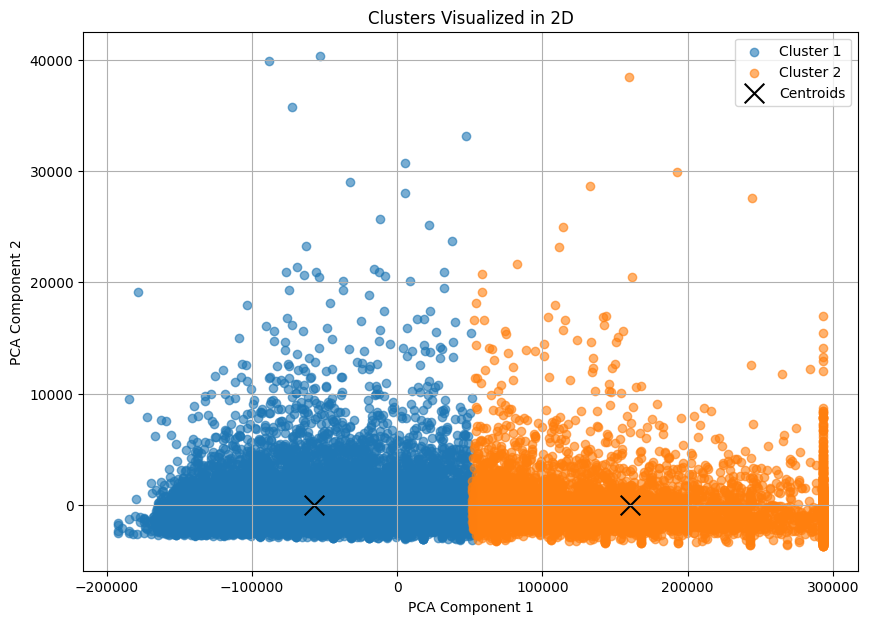

Mutual information between features and clusters: 
 [0.01489246 0.01341462 0.00105564 0.00627208 0.00073263 0.17435281
 0.57602753 0.16685603] 

PCA Components:
[[-0.21655596  0.48877609  0.4918594   0.47201771  0.49443666  0.0547945
   0.04379195 -0.00934277]
 [ 0.04304147  0.06387809 -0.06008244 -0.0836998  -0.04542782  0.69503023
   0.69880051 -0.09999302]]

Explained Variance Ratio:
[0.48549519 0.21343831]


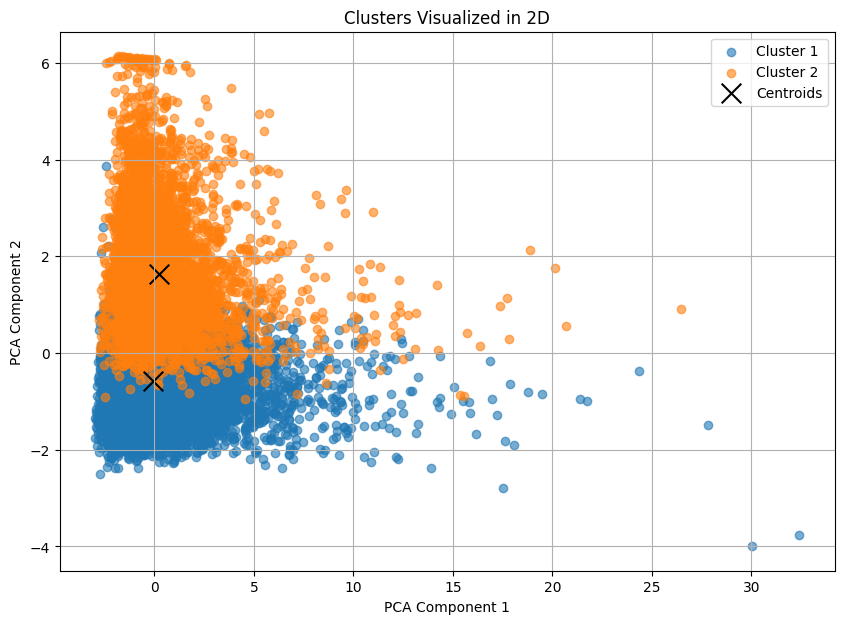

Time needed to run K-Means: 2.1696090698242188e-05


In [30]:
clusters, centroids, elapsed_time = evaluateKMeansOnRawData(data)
print(f"Time needed to run K-Means: {elapsed_time}")

K-Means cost: 121492.15066654411
Silhouette Score: 0.4310023326275964
PCA Components:
[[-0.21655596  0.48877609  0.4918594   0.47201771  0.49443666  0.0547945
   0.04379195 -0.00934277]
 [ 0.04304147  0.06387809 -0.06008244 -0.0836998  -0.04542782  0.69503023
   0.69880051 -0.09999302]]

Explained Variance Ratio:
[0.48549519 0.21343831]


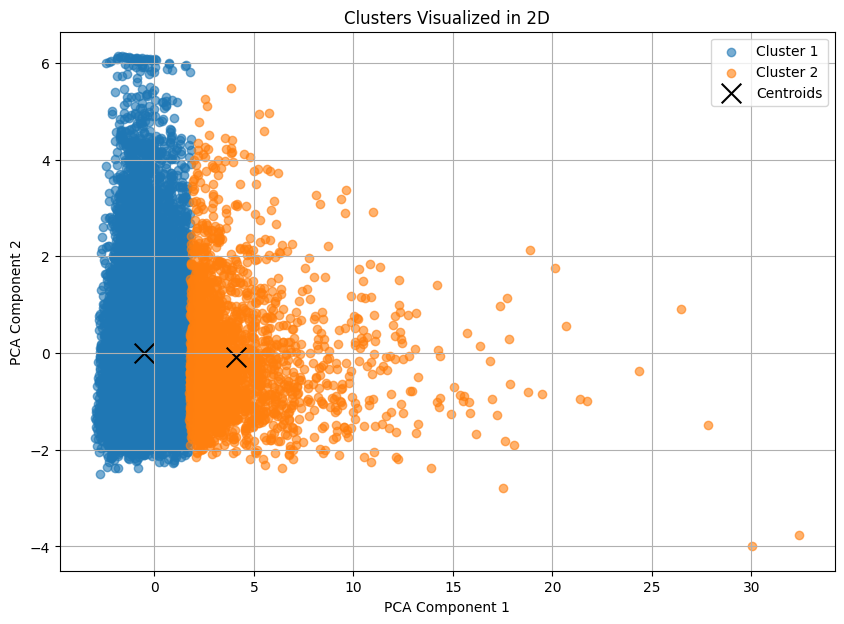

Mutual information between features and clusters: 
 [0.05631437 0.26542477 0.28642368 0.23691727 0.2903044  0.0130252
 0.00785999 0.02592355] 

PCA Components:
[[ 1.15177844e-05  2.53710308e-03  1.79836668e-04 -2.41510816e-04
   2.18291633e-04  1.13282065e-05  9.99996712e-01 -6.14768343e-07]
 [-1.89419228e-03  8.78810819e-01  1.61747210e-01  4.24104026e-01
   1.47162425e-01  6.62151325e-05 -2.18840646e-03  2.42459273e-06]]

Explained Variance Ratio:
[9.99528880e-01 4.48991296e-04]


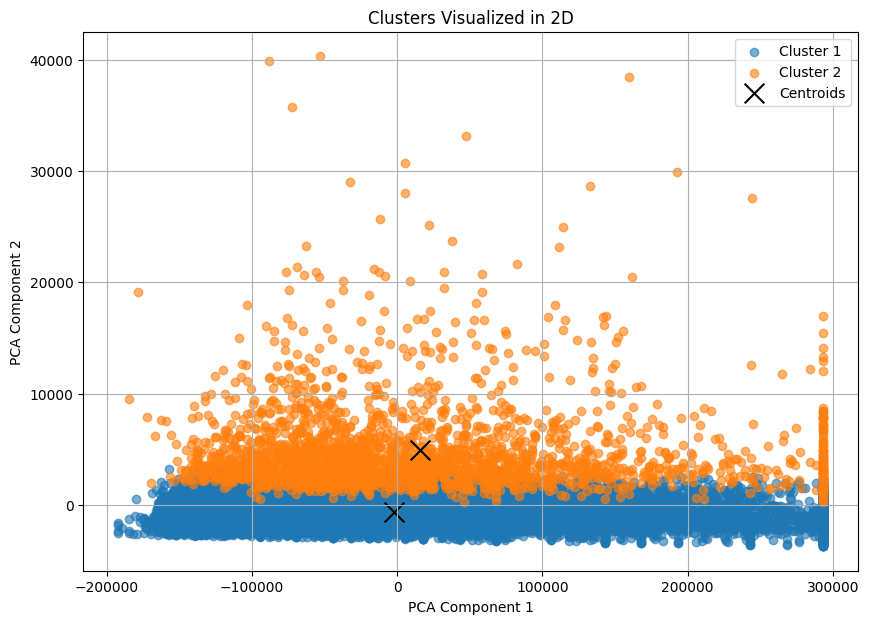

Time needed to run K-Means: 1.7404556274414062e-05


In [31]:
clusters, centroids, elapsed_time, _ = evaluateKMeansOnNormalizedData(data)
print(f"Time needed to run K-Means: {elapsed_time}")

This time there is no significant change in clustering in both spaces, so these features will be dropped as well to simplify our data.

<h2> Error Analysis </h2>

The clustering was particularly improved by the latitude and longitude transformation into a new derived feature. This made the clusters overlap less in both spaces. However, some feature engineering on the remaining fields could still enhance performances.

<h2> Experiment 4: Expand the feature space again, after noise removal </h2>

After removing noisy features, I am going to expand once again the raw features space with new features which may improve performances, by combining them as before.

In [32]:
# the following information may be relevant
data.loc[:, 'total_not_bedrooms'] = data['total_rooms'] - data['total_bedrooms']

# these ratios (and the final multiplication) involve some of the most important fields
data.loc[:, 'median_house_value_per_income'] = data['median_house_value'] / data['median_income']
data.loc[:, 'housing_median_age_per_household'] = data['housing_median_age'] / data['households']
data.loc[:, 'pop_per_household'] = data['population'] / data['households']
data.loc[:, 'rooms_per_household'] = data['total_rooms'] / data['households']
data.loc[:, 'median_house_value_per_age'] = data['median_house_value'] / data['housing_median_age']


data.loc[:, 'median_income_mult_population'] = data['median_income'] * data['population']
data.loc[:, 'distance_from_center_mult_households'] = data['distance_from_center'] * data['households']
data.loc[:, 'housing_median_age_pow3'] = data['housing_median_age'] ** 3
data.loc[:, 'distance_from_center_pow3'] = data['distance_from_center'] ** 3

data

housing_median_age  total_rooms  total_bedrooms  population  \
0                    41.0        880.0           129.0       322.0   
1                    21.0       7099.0          1106.0      2401.0   
2                    52.0       1467.0           190.0       496.0   
3                    52.0       1274.0           235.0       558.0   
4                    52.0       1627.0           280.0       565.0   
...                   ...          ...             ...         ...   
20635                25.0       1665.0           374.0       845.0   
20636                18.0        697.0           150.0       356.0   
20637                17.0       2254.0           485.0      1007.0   
20638                18.0       1860.0           409.0       741.0   
20639                16.0       2785.0           616.0      1387.0   

       households  median_income  median_house_value  distance_from_center  \
0           126.0         8.3252            452600.0              3.483001   
1          1138.0         8.3014            358500.0              3.462466   
2           177.0         7.2574            352100.0              3.471400   
3           219.0         5.6431            341300.0              3.479098   
4           259.0         3.8462            342200.0              3.479098   
...           ...            ...                 ...                   ...   
20635       330.0         1.5603             78100.0              4.137568   
20636       114.0         2.5568             77100.0              4.192350   
20637       433.0         1.7000             92300.0              4.141175   
20638       349.0         1.8672             84700.0              4.182032   
20639       530.0         2.3886             89400.0              4.094334   

       total_not_bedrooms  median_house_value_per_income  \
0                   751.0                   54365.060299   
1                  5993.0                   43185.486785   
2                  1277.0                   48515.997465   
3                  1039.0                   60480.941327   
4                  1347.0                   88970.932349   
...                   ...                            ...   
20635              1291.0                   50054.476703   
20636               547.0                   30154.881101   
20637              1769.0                   54294.117647   
20638              1451.0                   45362.039417   
20639              2169.0                   37427.781964   

       housing_median_age_per_household  pop_per_household  \
0                              0.325397           2.555556   
1                              0.018453           2.109842   
2                              0.293785           2.802260   
3                              0.237443           2.547945   
4                              0.200772           2.181467   
...                                 ...                ...   
20635                          0.075758           2.560606   
20636                          0.157895           3.122807   
20637                          0.039261           2.325635   
20638                          0.051576           2.123209   
20639                          0.030189           2.616981   

       rooms_per_household  median_house_value_per_age  \
0                 6.984127                11039.024390   
1                 6.238137                17071.428571   
2                 8.288136                 6771.153846   
3                 5.817352                 6563.461538   
4                 6.281853                 6580.769231   
...                    ...                         ...   
20635             5.045455                 3124.000000   
20636             6.114035                 4283.333333   
20637             5.205543                 5429.411765   
20638             5.329513                 4705.555556   
20639             5.254717                 5587.500000   

       median_income_mult_population  distance_from_center_mult_ho

K-Means cost: 139583562718114.1
Silhouette Score: 0.5369178664366487
PCA Components:
[[ 1.33714437e-05  2.36224609e-03  1.71049086e-04 -2.72842836e-04
   2.08834681e-04  1.08738975e-05  9.89132969e-01 -6.12839104e-07
   2.19119700e-03  1.31336828e-01  3.74117786e-08 -2.13012488e-06
   3.01381697e-06  4.11897673e-02  1.26806336e-02  2.57829725e-04
   4.99861244e-02 -5.86117881e-05]
 [ 2.87206809e-04 -1.78688589e-02 -2.66536083e-03 -7.12327734e-03
  -2.38499755e-03 -1.36991333e-05 -7.41621030e-02  1.93125441e-09
  -1.52034981e-02  2.40594742e-01  1.98147426e-06  2.77046306e-06
  -1.15569456e-05 -1.31228737e-01 -4.83072402e-02 -6.34725119e-03
   9.57290570e-01 -1.16895221e-05]]

Explained Variance Ratio:
[0.84412362 0.09864067]


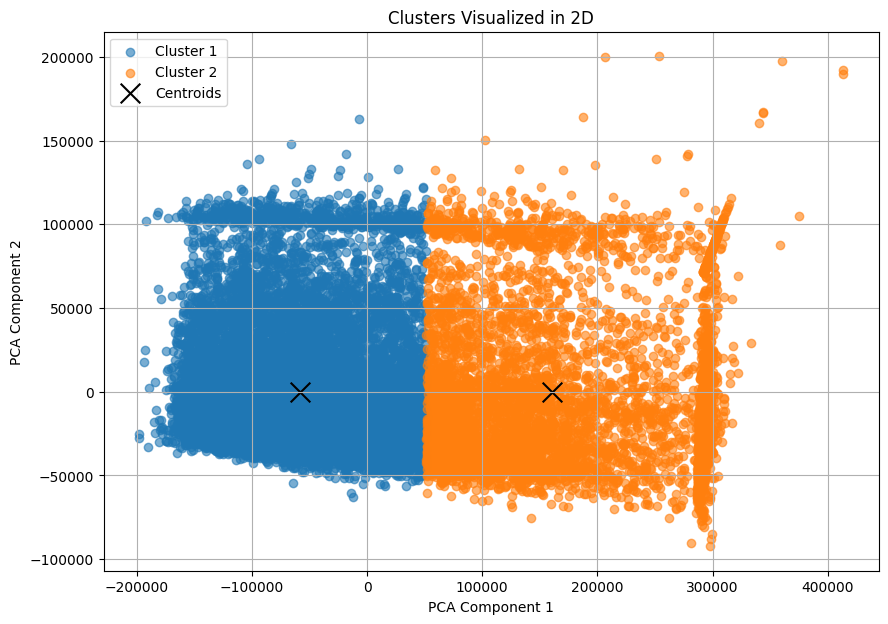

Mutual information between features and clusters: 
 [0.01197476 0.01271068 0.         0.00463916 0.         0.16832164
 0.56476356 0.17070404 0.01605197 0.12469056 0.         0.04655588
 0.05456252 0.20438235 0.03196544 0.00120163 0.0099101  0.17102756] 

PCA Components:
[[-1.87959284e-01  3.77792577e-01  3.61625054e-01  3.48250090e-01
   3.64384420e-01  8.40941108e-02  5.68749056e-02  1.69999219e-02
   3.73716324e-01 -2.34813280e-02 -7.33548731e-02 -4.39538158e-04
   3.41153061e-02  1.61279620e-01  3.44250108e-01  3.32965747e-01
  -1.56127871e-01 -3.03632257e-04]
 [-3.72444690e-02 -3.83171564e-03 -1.00235535e-01 -9.57329219e-02
  -9.82623555e-02  4.86805765e-01  4.86722684e-01 -3.40892358e-01
   1.87064000e-02  9.91155053e-02  4.54195875e-02  1.50133658e-02
   2.10826195e-01  3.21496624e-01  1.43203973e-01 -2.26469291e-01
  -1.68964919e-02 -3.83787928e-01]]

Explained Variance Ratio:
[0.36758683 0.12936234]


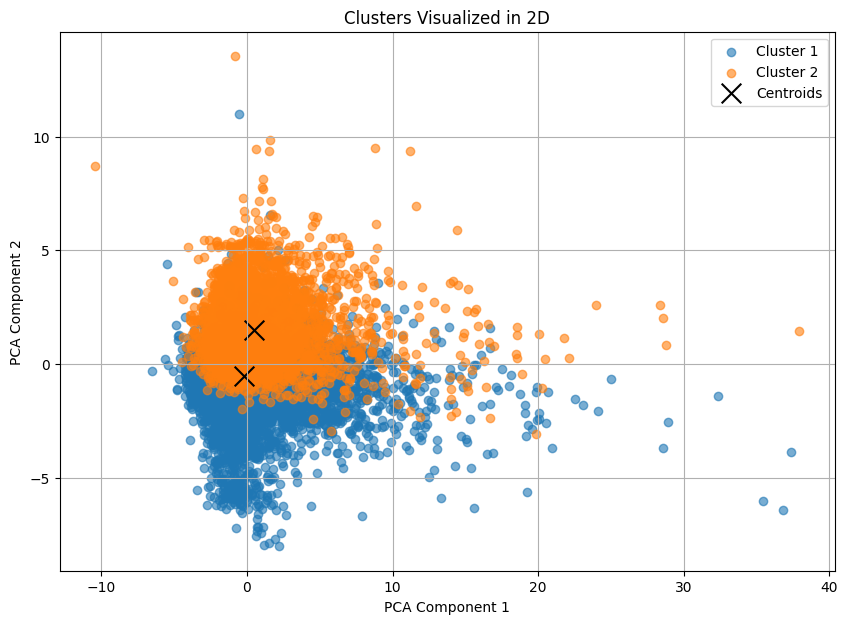

Time needed to run K-Means: 2.2411346435546875e-05


In [33]:
clusters, centroids, elapsed_time = evaluateKMeansOnRawData(data)
print(f"Time needed to run K-Means: {elapsed_time}")

K-Means cost: 298186.3830035328
Silhouette Score: 0.4144568053353308
PCA Components:
[[-1.87959284e-01  3.77792577e-01  3.61625054e-01  3.48250090e-01
   3.64384420e-01  8.40941108e-02  5.68749056e-02  1.69999219e-02
   3.73716324e-01 -2.34813280e-02 -7.33548731e-02 -4.39538158e-04
   3.41153061e-02  1.61279620e-01  3.44250108e-01  3.32965747e-01
  -1.56127871e-01 -3.03632257e-04]
 [-3.72444690e-02 -3.83171564e-03 -1.00235535e-01 -9.57329219e-02
  -9.82623555e-02  4.86805765e-01  4.86722684e-01 -3.40892358e-01
   1.87064000e-02  9.91155053e-02  4.54195875e-02  1.50133658e-02
   2.10826195e-01  3.21496624e-01  1.43203973e-01 -2.26469291e-01
  -1.68964919e-02 -3.83787928e-01]]

Explained Variance Ratio:
[0.36758683 0.12936234]


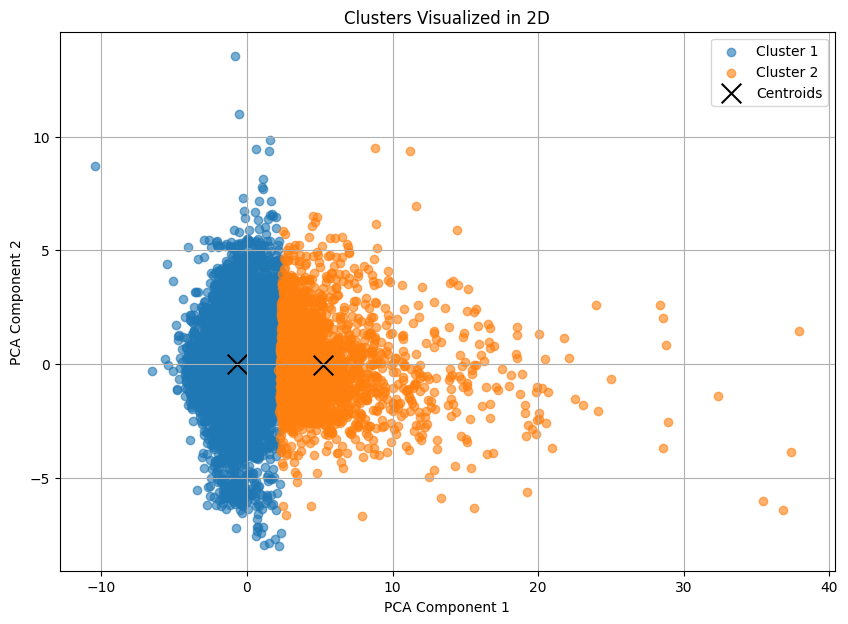

Mutual information between features and clusters: 
 [0.07078158 0.29218932 0.24733021 0.21731487 0.25286136 0.01985724
 0.01042837 0.02961399 0.27115017 0.00761882 0.20518389 0.00357898
 0.00656111 0.06606616 0.19742054 0.18855713 0.06707269 0.03007589] 

PCA Components:
[[ 1.33714437e-05  2.36224609e-03  1.71049086e-04 -2.72842836e-04
   2.08834681e-04  1.08738975e-05  9.89132969e-01 -6.12839104e-07
   2.19119700e-03  1.31336828e-01  3.74117786e-08 -2.13012488e-06
   3.01381697e-06  4.11897673e-02  1.26806336e-02  2.57829725e-04
   4.99861244e-02 -5.86117881e-05]
 [ 2.87206809e-04 -1.78688589e-02 -2.66536083e-03 -7.12327734e-03
  -2.38499755e-03 -1.36991333e-05 -7.41621030e-02  1.93125441e-09
  -1.52034981e-02  2.40594742e-01  1.98147426e-06  2.77046306e-06
  -1.15569456e-05 -1.31228737e-01 -4.83072402e-02 -6.34725119e-03
   9.57290570e-01 -1.16895221e-05]]

Explained Variance Ratio:
[0.84412362 0.09864067]


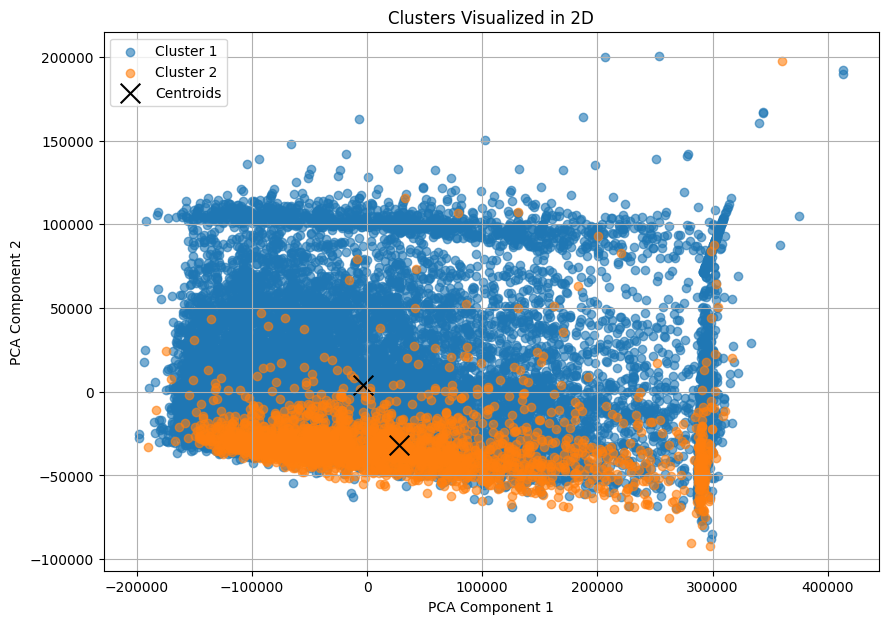

Time needed to run K-Means: 2.288818359375e-05


In [34]:
clusters, centroids, elapsed_time, data_scaled_augmented = evaluateKMeansOnNormalizedData(data)
print(f"Time needed to run K-Means: {elapsed_time}")

<h2> Error Analysis </h2>

By introducing new features, noise seemed to increase again, with the clusters overlapping again in the other spaces. However, the clusters seem to be better defined than before.
Matter of fact, the distance between the centroids was significantly increased, even though now the clusters in the rescaled space is characterized by significant overlapping in both cases.

<h2> Experiment 5: use dimensionality reduction on the expanded features</h2>

Here I applied once again PCA and Random Projections to project data to a lower dimensional space.


<h4>PCA</h4>


As before, I used the elbow method to understand the number of dimensions to keep.

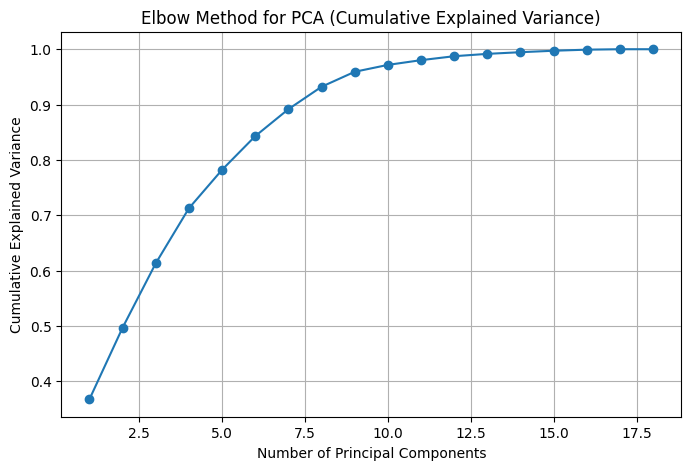

Cumulative explained variance: [0.36758683 0.49694917 0.61322955 0.71263894 0.78213788 0.84293487
 0.89165557 0.93214774 0.95923463 0.97166572 0.98023168 0.98736687
 0.99161484 0.99462463 0.99725664 0.99919015 1.         1.        ]
PCA Components: [[-1.87959284e-01  3.77792577e-01  3.61625054e-01  3.48250090e-01
   3.64384420e-01  8.40941108e-02  5.68749056e-02  1.69999219e-02
   3.73716324e-01 -2.34813280e-02 -7.33548731e-02 -4.39538158e-04
   3.41153061e-02  1.61279620e-01  3.44250108e-01  3.32965747e-01
  -1.56127871e-01 -3.03632257e-04]
 [-3.72444690e-02 -3.83171564e-03 -1.00235535e-01 -9.57329219e-02
  -9.82623555e-02  4.86805765e-01  4.86722684e-01 -3.40892358e-01
   1.87064000e-02  9.91155053e-02  4.54195875e-02  1.50133658e-02
   2.10826195e-01  3.21496624e-01  1.43203973e-01 -2.26469291e-01
  -1.68964919e-02 -3.83787928e-01]
 [ 4.74637380e-01  6.18143831e-02  1.46587799e-01  1.61780447e-01
   1.71360486e-01 -1.80437610e-01  8.84493029e-02 -3.06348675e-01
   4.07820497e-02  3.

In [35]:
elbowPCA(data_scaled_augmented)

In [36]:
pca_dims = 9  # number of dimensions to project to, chosen using the elbow method
pca = PCA(n_components=pca_dims)
data_reduced = pca.fit_transform(data)
pca = PCA(n_components=pca_dims)
data_reduced_scaled = pca.fit_transform(data_scaled_augmented)
print(f"Projecting the datasets to {pca_dims} dimensions with PCA")

Projecting the datasets to 9 dimensions with PCA


K-Means cost: 139583471827429.38
Silhouette Score: 0.5369180913794656
PCA Components:
[[ 1.00000000e+00  2.86905032e-16 -1.63770876e-16 -3.54959298e-17
  -4.43903122e-17 -1.24439754e-17  1.94955614e-17  8.82298254e-19
  -2.81568318e-17]
 [-2.86905032e-16  1.00000000e+00 -4.44089210e-16 -4.16333634e-17
   0.00000000e+00  2.28983499e-16  1.04083409e-16  1.17527515e-16
   6.80011603e-16]]

Explained Variance Ratio:
[0.84412385 0.09864069]


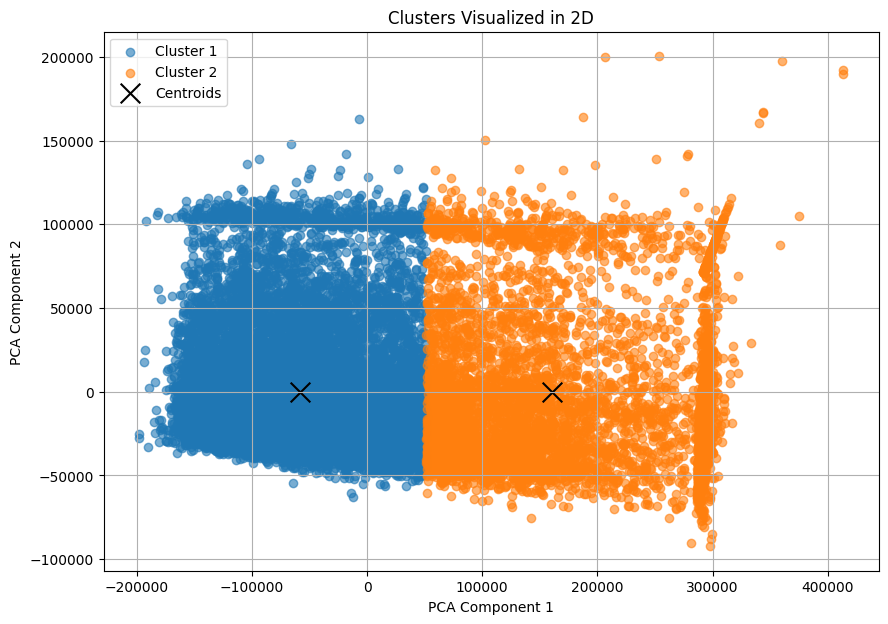

Mutual information between features and clusters: 
 [0.57799055 0.06770547 0.05331523 0.15110807 0.024579   0.02642535
 0.00171744 0.02462408 0.01801076] 

Time needed to run K-Means: 1.6927719116210938e-05


In [37]:
clusters, centroids, elapsed_time = evaluateKMeans(data_reduced)
print(f"Time needed to run K-Means: {elapsed_time}")

K-Means cost: 283057.0271528655
Silhouette Score: 0.4211697460347939
PCA Components:
[[ 1.00000000e+00  1.22297330e-16  1.91191913e-16  5.99836287e-17
  -4.09966848e-17 -2.47334070e-17  5.37176224e-17 -9.58084968e-17
  -6.13375899e-17]
 [-1.22297330e-16  1.00000000e+00 -1.44328993e-15 -1.33226763e-15
  -8.32667268e-17  6.80011603e-16  3.33066907e-16 -5.55111512e-17
  -8.32667268e-17]]

Explained Variance Ratio:
[0.38320846 0.13485996]


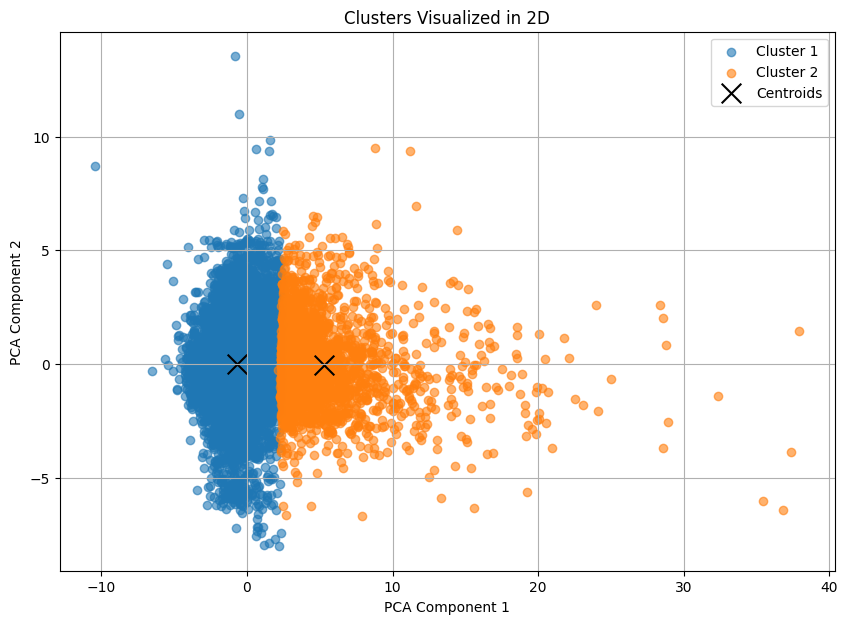

Mutual information between features and clusters: 
 [0.3475899  0.01015539 0.00332609 0.00457106 0.0058745  0.00509476
 0.02488184 0.00106675 0.02756764] 

Time needed to run K-Means: 2.1457672119140625e-05


In [38]:
clusters, centroids, elapsed_time = evaluateKMeans(data_reduced_scaled)
print(f"Time needed to run K-Means: {elapsed_time}")

As before, applying PCA to reduce dimensionality does not impact the K-Means clusters, that look exaclty like those in the full features spaces.

<h4>Gaussian Random Projection </h4>

In [39]:
grp = GaussianRandomProjection(n_components=pca_dims, random_state=seed)
data_reduced = grp.fit_transform(data)
grp = GaussianRandomProjection(n_components=pca_dims, random_state=seed)
data_reduced_scaled = grp.fit_transform(data_scaled_augmented)
print(f"Projecting the datasets to {grp.components_.shape[0]} dimensions with PCA")


Projecting the datasets to 9 dimensions with PCA


K-Means cost: 101764223790730.92
Silhouette Score: 0.5100250116366637
PCA Components:
[[-0.0078749  -0.25770887  0.06661283 -0.3746472   0.62570109  0.41137094
   0.24817012 -0.37325908  0.16458333]
 [ 0.50115644  0.62739254  0.07249941 -0.37288854  0.01438299 -0.3275137
   0.16474202 -0.2756045   0.01867981]]

Explained Variance Ratio:
[0.77811338 0.11038929]


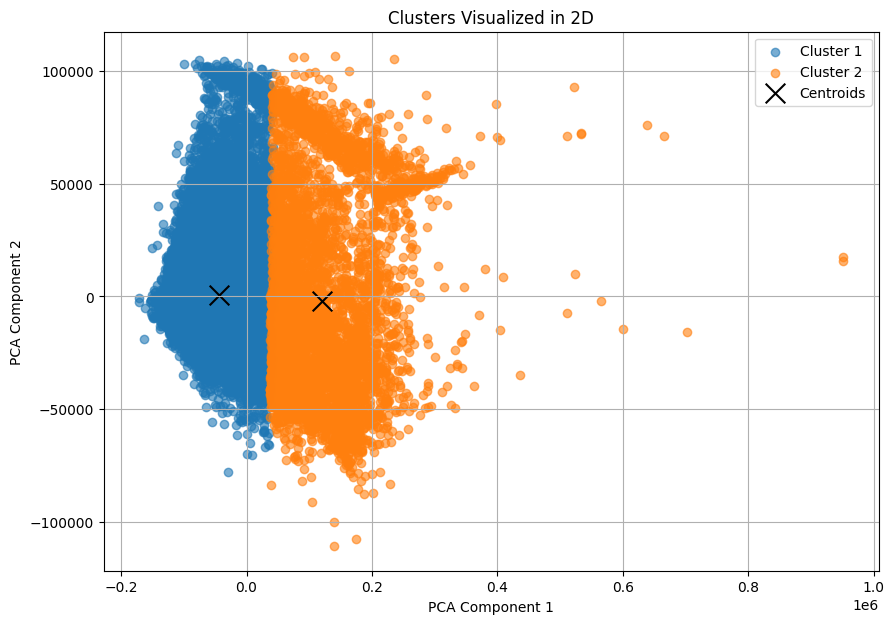

Mutual information between features and clusters: 
 [0.11213284 0.2477414  0.33383628 0.24649107 0.52039531 0.37744004
 0.33391994 0.38325428 0.37122848] 

Time needed to run K-Means: 2.2172927856445312e-05


In [40]:
clusters, centroids, elapsed_time = evaluateKMeans(data_reduced)
print(f"Time needed to run K-Means: {elapsed_time}")

K-Means cost: 369082.80872020277
Silhouette Score: 0.43304377055973703
PCA Components:
[[-0.18403227 -0.0261315  -0.3515031   0.23037067 -0.04416885  0.68029372
  -0.42637193 -0.2093427   0.31377759]
 [ 0.36692325 -0.22563427  0.52010711 -0.10163644  0.55181242  0.41215002
   0.05097856 -0.23303717 -0.04842945]]

Explained Variance Ratio:
[0.49447733 0.2666439 ]


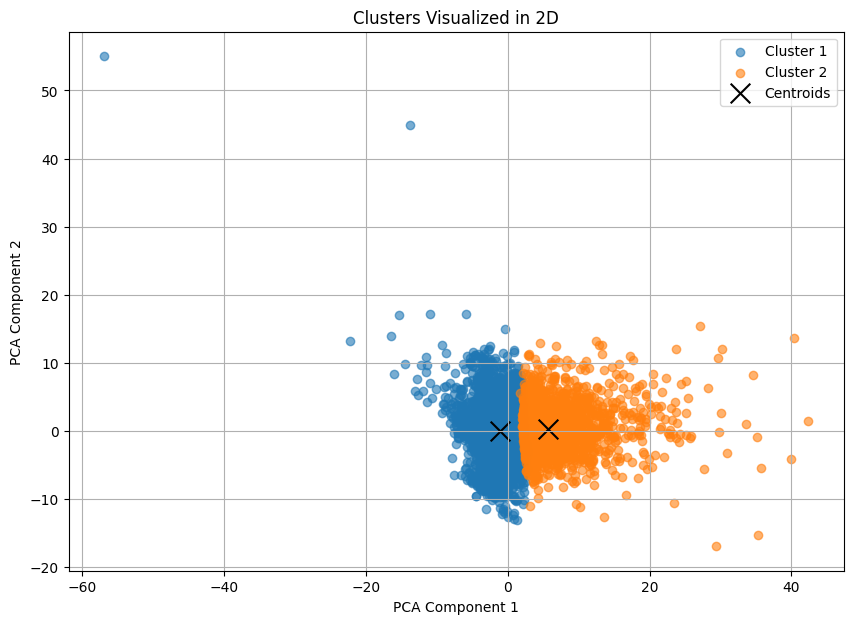

Mutual information between features and clusters: 
 [0.04487357 0.02340586 0.13560745 0.11360283 0.01504429 0.30777461
 0.31646375 0.18629214 0.29814456] 

Time needed to run K-Means: 1.6450881958007812e-05


In [41]:
clusters, centroids, elapsed_time = evaluateKMeans(data_reduced_scaled)
print(f"Time needed to run K-Means: {elapsed_time}")

Random projection instead seems to suffer from the noise and distort the feature space.

<h2>Error Analysis</h2>

After reducing dimensionality, noise was reduced in the raw space, while in the normalized space there was no noticeable change.


<h2>Final considerations</h2>

Overall it is worth noticing that the optimal number of clusters using silhouette method was 2 in almost all experiments in both spaces. These made me guess that a clustering in one of the spaces could work well also in the other. This was not however guaranteed at all and even trying to improve clustering in one of the spaces has been really difficult.
The best clustering for this goal was in my opinion achieved by the third experiment.

Feature engineering only usually enhanced performances in one of the two spaces and finding a way to combine transformations that could work for both was a complicated challenge.

<h2> Bonus: Experiment 0, brute force </h2>

This was my actually first experiment, trying to bruteforce feature engineering through a series of transformations. Eventually, It didn't work out.

In [42]:
data = pd.read_csv('housing.csv')
label_encoder = LabelEncoder()
data['ocean_proximity_indexed'] = label_encoder.fit_transform(data['ocean_proximity'])
data = data.drop(columns=['ocean_proximity'])
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_array = one_hot_encoder.fit_transform(data[['ocean_proximity_indexed']])
encoded_columns = [f"ocean_proximity_{category}" for category in label_encoder.classes_]
encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns)
data = data.drop(columns=['ocean_proximity_indexed'])
data = pd.concat([data, encoded_df], axis=1)


for col in data.columns[2:9]:

    # create new features based on transformations
    data.loc[:, f'{col}^2'] = data[col] ** 2
    data.loc[:, f'{col}^3'] = data[col] ** 3
    data.loc[:, f'e^{col}'] = np.exp(data[col])
    data.loc[:, f'log(1+{col})'] = np.log1p(data[col])

data

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       ocean_proximity_<1H OCEAN  ...   e^households  log(1+households)  \
0                            0.0  ...   5.261441e+54           4.844187   
1                            0.0  ...            inf           7.037906   
2                            0.0  ...   7.415207e+76           5.181784   
3                            0.0  ...   1.289708e+95           5.393628   
4                            0.0  ...  3.035784e+112           5.560682   
...                          ...  ...            ...                ...   
20635                        0.0  ...  2.075769e+143           5.802118   
20636                        0.0  ...   3.232741e+49           4.744932   
20637                        0.0  ...  1.120755e+188           6.073045   
20638                        0.0  ...  3.704880e+151           5.857933   
20639                        0.0  ...  1.499945e+230           6.274762   

       median_income^2  median_income^3  e^median_income  \
0            69.308955       577.010912      4126.562438   
1            68.913242       572.076387      4029.509760   
2            52.669855       382.246204      1418.563473   
3            31.844578       179.702136       282.336607   
4            14.793254        56.897815        46.814828   
...                ...              ...              ...   
20635         2.434536         3.798607         4.760249   
20636         6.537226        16.714380        12.894489   
20637         2.890000         4.913000         5.473947   
20638         3.486436         6.509873         6.470155   
20639         5.705410        13.627942        10.898226   

       log(1+median_income)  median_house_value^2  median_house_value^3  \
0                  2.232720          2.048468e+11          9.271364e+16   
1                  2.230165          1.285222e+11          4.607523e+16   
2                  2.111110          1.239744e+11          4.365139e+16   
3                  1.893579          1.164857e+11          3.975657e+16   
4                  1.578195          1.171008e+11          4.007191e+16   
...                     ...                   ...                   ...   
20635              0.940124          6.099610e+09          4.763795e+14   
20636              

In [43]:
columns = data.columns[2:9]
print(columns)

for col_x in columns:
    for col_y in columns:
        if col_x != col_y:
            # create the new features: x - y, x + y, x * y, x / y
            data.loc[:, f'{col_x}-{col_y}'] = data[col_x] - data[col_y]
            data.loc[:, f'{col_x}+{col_y}'] = data[col_x] + data[col_y]
            data.loc[:, f'{col_x}*{col_y}'] = data[col_x] * data[col_y]

            # avoid division by zero
            data.loc[:, f'{col_x}/{col_y}'] = np.where(data[col_y] != 0, data[col_x] / data[col_y], 0)

data

Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income', 'median_house_value'],
      dtype='object')


<ipython-input-43-4f226f56e280>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{col_x}*{col_y}'] = data[col_x] * data[col_y]
<ipython-input-43-4f226f56e280>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, f'{col_x}/{col_y}'] = np.where(data[col_y] != 0, data[col_x] / data[col_y], 0)
<ipython-input-43-4f226f56e280>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       ocean_proximity_<1H OCEAN  ...  median_house_value*population  \
0                            0.0  ...                    145737200.0   
1                            0.0  ...                    860758500.0   
2                            0.0  ...                    174641600.0   
3                            0.0  ...                    190445400.0   
4                            0.0  ...                    193343000.0   
...                          ...  ...                            ...   
20635                        0.0  ...                     65994500.0   
20636                        0.0  ...                     27447600.0   
20637                        0.0  ...                     92946100.0   
20638                        0.0  ...                     62762700.0   
20639                        0.0  ...                    123997800.0   

       median_house_value/population  median_house_value-households  \
0                        1405.590062                       452474.0   
1                         149.312786                       357362.0   
2                         709.879032                       351923.0   
3                         611.648746                       341081.0   
4                         605.663717                       341941.0   
...                              ...                            ...   
20635                      92.426036                        77770.0   
20636                     216.573034                        76986.0   
20637                      91.658391                        91867.0   
20638                     114.304993                        84351.0   
20639                      64.455660                        88870.0   

       median_house_value+households  median_house_value*households  \
0                           452726.0                     57027600.0   
1                           359638.0                    407973000.0   
2                           352277.0                     62321700.0   
3                           341519.0                     74744700.0   
4                           342459.0                     88629800.0   
...                              ...                            ...   
20635                     

In [44]:
# drop columns with NaN or Inf values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
ocean_feature_indices = [data.columns.get_loc(col) for col in ocean_features]

K-Means cost: 1.3603036143581843e+46
Silhouette Score: 0.9947325360944422
PCA Components:
[[-3.72240823e-23 -0.00000000e+00  1.46960216e-19  1.00397311e-18
  -5.47083940e-19 -1.62907713e-20 -3.87912921e-18 -3.04863157e-17
   6.77464915e-18  1.49967003e-17  1.03241561e-17  1.37570231e-17
   6.14460992e-18 -3.44793478e-18  2.95948813e-18  1.00000000e+00
   2.00618031e-23 -2.11368524e-16 -2.50680395e-12 -8.99055520e-24
  -6.22260684e-17 -3.93013261e-13 -1.06877720e-23 -5.85558805e-18
  -1.15982974e-14 -7.28282527e-24  4.85377037e-23  9.86579365e-22
   8.46289606e-19 -5.87838577e-25  1.09458907e-12  5.29427386e-07
   7.87352196e-24  2.30900620e-20 -2.17490960e-20  8.88886749e-19
   1.29860951e-24  1.47705307e-20 -1.34295647e-20  3.45117003e-19
   1.97158936e-24  4.16505863e-21 -2.82409259e-21  1.95473233e-19
   6.01247286e-24  6.70417038e-22  6.70549003e-22  2.68151594e-21
   2.41127315e-22 -1.91647755e-18  1.91781852e-18  2.33943282e-16
   2.50867733e-27 -2.30900620e-20 -2.17490960e-20  8

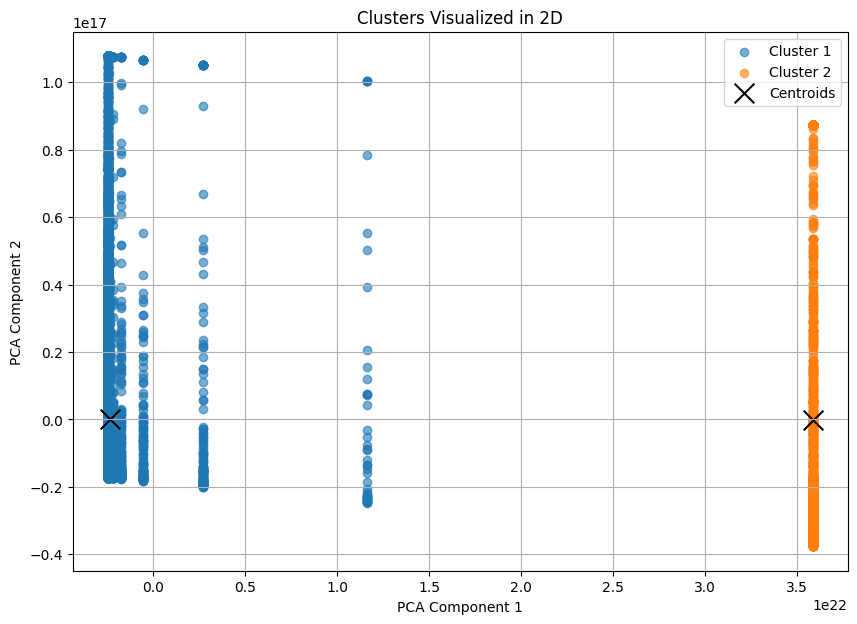

Mutual information between features and clusters: 
 [0.06146128 0.06636959 0.23170073 0.00720931 0.01182199 0.00631967
 0.00298493 0.0162239  0.01019292 0.00804883 0.00068939 0.02997197
 0.         0.23167651 0.23182185 0.23172496 0.2318703  0.00919713
 0.00998427 0.01009162 0.00945794 0.01012842 0.01032704 0.00436184
 0.00493559 0.00598849 0.00304501 0.00290543 0.00214301 0.00280871
 0.01749437 0.01842861 0.01581848 0.00933983 0.0090547  0.02146443
 0.04837017 0.01189819 0.01102997 0.01456277 0.05774248 0.01011507
 0.00480671 0.05879717 0.07650666 0.18904101 0.20400368 0.04847363
 0.04711301 0.07550087 0.07527719 0.09611587 0.07026159 0.0084225
 0.00849265 0.02121509 0.04864069 0.00419388 0.00764389 0.0106534
 0.00251833 0.00926766 0.00779918 0.00797408 0.00308965 0.00944594
 0.0077844  0.00297775 0.0091334  0.01332951 0.014461   0.00510457
 0.01758439 0.01283879 0.00853531 0.01477023 0.05833749 0.00565689
 0.00751513 0.01067233 0.00255556 0.01576749 0.00571122 0.00745459
 0.01053674 

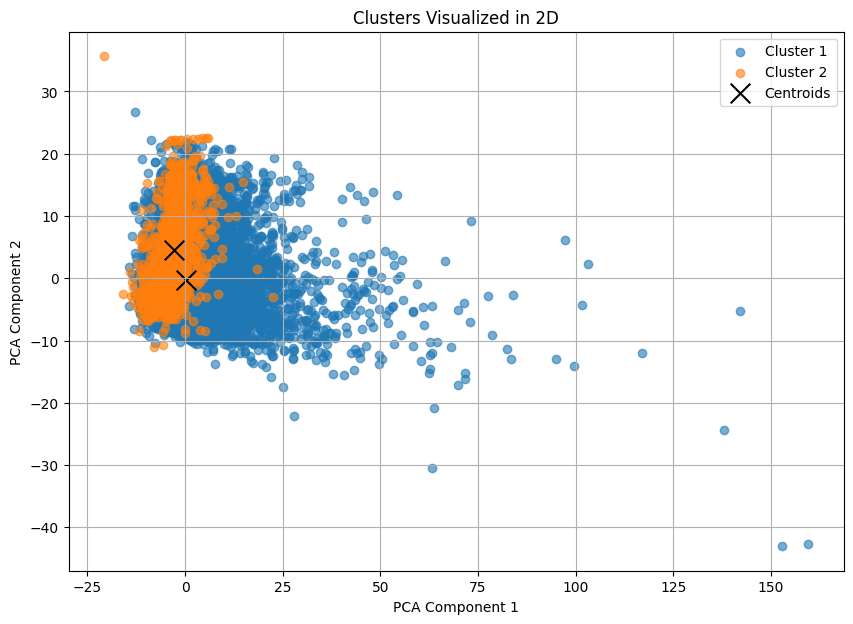

Time needed to run K-Means: 2.1457672119140625e-05


In [45]:
clusters, centroids, elapsed_time = evaluateKMeansOnRawData(data, not_normalize=ocean_feature_indices)
print(f"Time needed to run K-Means: {elapsed_time}")

K-Means cost: 2434173.1821354567
Silhouette Score: 0.47520622025416603
PCA Components:
[[ 8.01435525e-03 -1.11425799e-02 -4.40565197e-02  1.24845300e-01
   1.18530957e-01  1.22043103e-01  2.67539263e-02  2.60456618e-02
  -3.91617237e-02 -3.47224226e-02 -1.24346588e-02 -4.74605327e-02
   1.07495343e-01  7.99727359e-02  9.96847226e-02  8.41034066e-02
   4.23356018e-02  9.43181711e-02  1.10886530e-01  8.69295021e-02
   9.73175282e-02  2.07316632e-02  1.40068515e-02  5.27367264e-04
   2.91940848e-02  2.24022168e-02  1.92162559e-02  2.84275424e-02
  -1.24837483e-01  1.24849529e-01  7.40802512e-02 -2.41142166e-02
  -1.18623373e-01  1.18424533e-01  6.18761709e-02 -2.79490552e-02
  -1.22215169e-01  1.21746333e-01  6.47018491e-02 -2.18874352e-02
  -4.67422336e-02 -4.02836948e-02 -1.26799264e-02 -4.04384359e-02
  -2.60507667e-02  2.60405566e-02 -6.28408957e-03 -4.24459514e-02
   1.24837483e-01  1.24849529e-01  7.40802512e-02  8.89440649e-02
   1.02767143e-01  1.26831520e-01  1.06803358e-01  5.18

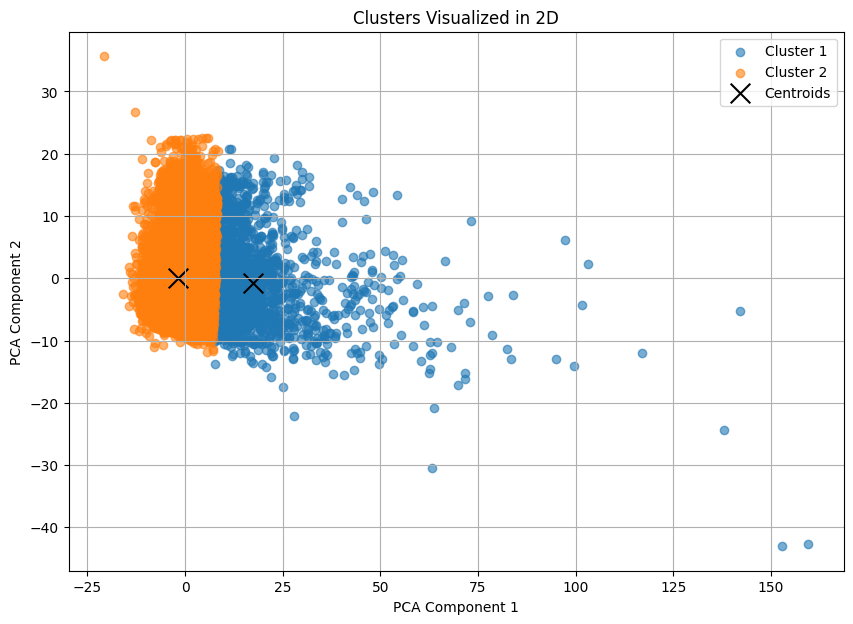

Mutual information between features and clusters: 
 [0.01730885 0.01373645 0.04595499 0.24958701 0.2052864  0.23346428
 0.01490204 0.00790892 0.04618532 0.04730835 0.03833766 0.05064841
 0.24989543 0.24976072 0.24970522 0.20492906 0.20473213 0.20486672
 0.23335956 0.23237031 0.23310005 0.01437628 0.01446191 0.01527848
 0.0151539  0.00862017 0.01052559 0.00994798 0.24991131 0.25133999
 0.06339254 0.15418657 0.20444023 0.20463652 0.04528786 0.15541662
 0.23274951 0.23084427 0.05636377 0.1603418  0.04934903 0.03846756
 0.01687334 0.0416794  0.02017493 0.01847787 0.0192368  0.05056008
 0.25011725 0.2514048  0.06326402 0.15419623 0.16919664 0.27395723
 0.2690908  0.00509116 0.23220817 0.26139655 0.26764929 0.00377202
 0.24923306 0.24915833 0.14684541 0.13106754 0.0210117  0.02295804
 0.14150174 0.09787453 0.20362224 0.20537353 0.04559458 0.15540355
 0.16924673 0.27392315 0.2690908  0.00502162 0.15871062 0.223056
 0.23748102 0.00255902 0.20332669 0.20482225 0.17717809 0.08023749
 0.01986598 

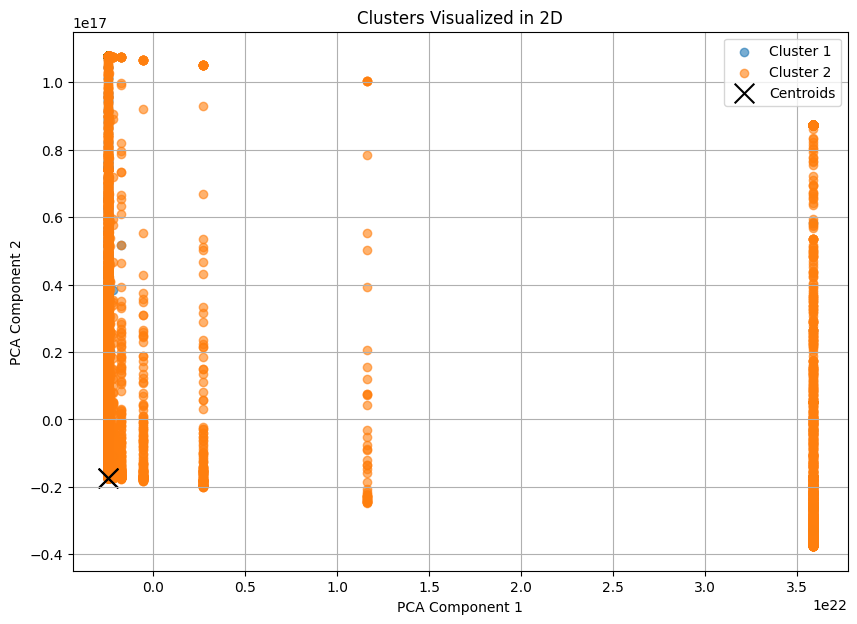

Time needed to run K-Means: 2.6464462280273438e-05


In [46]:
clusters, centroids, elapsed_time, data_scaled_augmented = evaluateKMeansOnNormalizedData(data, not_normalize=ocean_feature_indices)
print(f"Time needed to run K-Means: {elapsed_time}")

In [47]:
print(*[c for c in data.columns], sep='\n')

longitude
latitude
housing_median_age
total_rooms
population
households
median_income
median_house_value
ocean_proximity_<1H OCEAN
ocean_proximity_INLAND
ocean_proximity_ISLAND
ocean_proximity_NEAR BAY
ocean_proximity_NEAR OCEAN
housing_median_age^2
housing_median_age^3
e^housing_median_age
log(1+housing_median_age)
total_rooms^2
total_rooms^3
log(1+total_rooms)
population^2
population^3
log(1+population)
households^2
households^3
log(1+households)
median_income^2
median_income^3
e^median_income
log(1+median_income)
median_house_value^2
median_house_value^3
log(1+median_house_value)
housing_median_age-total_rooms
housing_median_age+total_rooms
housing_median_age*total_rooms
housing_median_age/total_rooms
housing_median_age-population
housing_median_age+population
housing_median_age*population
housing_median_age/population
housing_median_age-households
housing_median_age+households
housing_median_age*households
housing_median_age/households
housing_median_age-median_income
housing_media